# Group 23 - Members

|Name|Student ID|
|-|-|
|Ricardo Montenegro Dona|20221359|
|Felix Gayer|20220320|
|David Halder|20220632|
|Lukas Stark|20220626|

# Imports

In [ ]:
# basics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import ast
import  os
import  shutil

# preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('snowball_data')
nltk.download('averaged_perceptron_tagger')

# sklearn & imblearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, RocCurveDisplay, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# tensorflow
# !pip install tensorflow-text
# !pip install tf-models-official

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
try:
   import tensorflow_hub as hub
except:
  !pip install tensorflow-hub
  import tensorflow_hub as hub
try:
   import tensorflow_text as text
except:
  !pip install tensorflow-text
  import tensorflow_text as text

# BERT (Pytorch)
try:
  import torch
  from transformers import DistilBertTokenizer, DistilBertModel
except:
  !pip install torch
  !pip install torch transformers
  from transformers import DistilBertTokenizer, DistilBertModel

# sentiment analysis (vaderSentiment)
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except:
    !pip install vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# unidecode
try:
  from unidecode import unidecode
except:
  !pip install unidecode
  from unidecode import unidecode

# word2vec
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

# pycld2
try:
  import pycld2 as cld2
except:
  !pip install pycld2
  import pycld2 as cld2

# wordcloud
try:
  from wordcloud import WordCloud
except:
  !pip install wordcloud
  from wordcloud import WordCloud

tf.get_logger().setLevel('ERROR')

# Load Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd '/content/drive/MyDrive/TextMiningProject/TextMiningAirbnb'

In [ ]:
train = pd.read_excel('Data/train.xlsx', index_col='index')
train_reviews = pd.read_excel('Data/train_reviews.xlsx', index_col='index')

# 1. Exploratory Data Analysis

## 1.1 Functions - EDA

In [ ]:
regex_patterns = {
    # manually identified patterns
    r'_x005f_x000d_':               ' ',
    r'_x000d_':                     ' ',
    r'm2':                          'squaremeter',
    r'sm':                          'squaremeter',
    r'sqm':                         'squaremeter',
    r'm²':                          'squaremeter',
    r'license[ number]+[0-9a-z]+':  ' ',
    r'(\\b\\w)\\1+\\b':             ' ',

    # basic patterns
    # remove url
    r'http\S+':                     ' ',
    # remove html tags
    r'<.*?>':                       ' ',
    # remove punctuation
    r'[^\w\s]':                     ' ',
    # remove numbers
    r'\d+':                         ' ',
    # remove multiple whitespace
    r'\s+':                         ' ',
    # remove newline
    r'\n':                          ' '
}

###########################################################################################################################################

def prepare_data_eda(dataframe):

  categorical_features = list(dataframe.select_dtypes(exclude = np.number).columns)
  stop_words = set(stopwords.words('english'))

  # lowercase non-numeric features and convert to ASCII using unidecode
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: unidecode(x.lower()) if type(x) == str else '')

  # drop duplicates
  dataframe = dataframe.reset_index()
  dataframe = dataframe.drop_duplicates()

  # fill empty cells
  for col in categorical_features:
    dataframe[col] = dataframe[col].fillna('')

  # regex
  for col in categorical_features:
    dataframe[col + '_regex'] = dataframe[col]
    for key, value in regex_patterns.items():
      dataframe[col + '_regex'] = dataframe[col + '_regex'].apply(lambda x: re.sub(key,value,x))

  # update categorical_features
  categorical_features = list(dataframe.select_dtypes(exclude = np.number).columns)

  # detect language
  for col in categorical_features:
    new_col = col + '_lang'
    dataframe[new_col] = dataframe[col].apply(lambda x: cld2.detect(x)[-1][0][1] if len(x) < 5000 else 'text has more than 5k characters')

  # tokenize and remove stopwords
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

  return dataframe

###########################################################################################################################################

def plot_most_frequent_tokens(dataframe, n=20, label_filter='all'):

    rows = int(len(dataframe.columns)/2)
    dataframe_columns = dataframe.columns

    if 'unlisted' in dataframe.columns:
      if label_filter == 'unlisted':
        dataframe = dataframe[dataframe.unlisted == 1]
      elif label_filter == 'listed':
        dataframe = dataframe[dataframe.unlisted == 0]
    elif 'unlisted' not in dataframe.columns:
      dataframe = dataframe.merge(train[['unlisted']], left_index=True, right_index=True, how='left')
      if label_filter == 'unlisted':
        dataframe = dataframe[dataframe.unlisted == 1]
      elif label_filter == 'listed':
        dataframe = dataframe[dataframe.unlisted == 0]

    if rows > 1:
      fig, ax = plt.subplots(rows, 2, figsize=(15,10))
    else:
      fig, ax = plt.subplots(rows, 2, figsize=(15,7))

    ax_list = ax.flatten()

    color_counter = 0
    for i, column in enumerate(dataframe_columns):
        # Calculate the most frequent tokens in the current column
        tokens = dataframe[column].explode().value_counts().head(n)

        # Plot the most frequent tokens as a bar chart in subplot column 1
        if (color_counter % 2):
          ax_list[i].barh(tokens.index, tokens.values, color='olive')
        else:
          ax_list[i].barh(tokens.index, tokens.values, color='salmon')

        color_counter += 1

        ax_list[i].set_title(column.title())

    # Title
    if label_filter == 'all':
      fig.suptitle('Tokens Count (All Labels)')
    elif label_filter == 'unlisted':
      fig.suptitle('Tokens Count (Unlisted)')
    elif label_filter == 'listed':
      fig.suptitle('Tokens Count (Listed)')

    # Adjust spacing
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Show the plot
    return plt.show()

###########################################################################################################################################

def language_count(dataframe):
  if len(dataframe.columns) > 1:
        fig, ax = plt.subplots(len(dataframe.columns), figsize=(10, 5*len(dataframe.columns)))
        ax_list = ax.flatten()
  else:
      fig, ax = plt.subplots(figsize=(10, 5))
      ax_list = [ax]

  for i, col in enumerate(dataframe.columns):
      lang_counts = dataframe[col].value_counts().head(10)
      if 'text has more than 5k characters' in lang_counts.index:
        lang_counts = lang_counts.drop('text has more than 5k characters')

      ax_list[i].barh(lang_counts.index, lang_counts.values)
      ax_list[i].set_title(' '.join(col.split('_')[:-1]).title() + ' - Language Count')
      ax_list[i].set_xlabel('Language')
      ax_list[i].set_ylabel('Count')

  plt.tight_layout()
  plt.show()

###########################################################################################################################################

def word_clouds(dataframe):
  if len(dataframe.columns) > 1:
        fig, ax = plt.subplots(len(dataframe.columns), figsize=(10, 5*len(dataframe.columns)))
        ax_list = ax.flatten()
  else:
      fig, ax = plt.subplots(figsize=(10, 5))
      ax_list = [ax]

  for i, col in enumerate(dataframe.columns):
      dataframe[col+'_word_cloud'] = dataframe[col].apply(lambda x: ' '.join(x))
      column_text = ' '.join(dataframe[col+'_word_cloud'].astype(str))

      wordcloud = WordCloud(width=800, height=400, background_color='white').generate(column_text)

      ax_list[i].imshow(wordcloud, interpolation='bilinear')
      ax_list[i].set_title(' '.join(col.split('_')[:-1]).title() + ' - Wordcloud')
      ax_list[i].set_xticks([])
      ax_list[i].set_yticks([])

  plt.tight_layout()
  plt.show()

###########################################################################################################################################

def nr_of_comments(dataframe):
  # Compute the value counts for the column
  value_counts = dataframe['index'].value_counts()

  # Sort the values in descending order
  sorted_values = value_counts.sort_values(ascending=False).head(10)

  # Create the countplot with sorted values
  sns.countplot(y='index', data=dataframe, order=sorted_values.index, color='steelblue', orient='h')
  plt.title("Top 10 Properties with more Comments")
  plt.xlabel('Nº of Comments')
  plt.ylabel('Property ID')
  plt.show()

###########################################################################################################################################

def most_common_comments(dataframe):
  # Compute the value counts most common comments
  value_counts = dataframe['comments'].value_counts()

  # Sort the values in descending order
  sorted_values = value_counts.sort_values(ascending=False).head(10)

  # Create the countplot with sorted values
  sns.countplot(y='comments', data=dataframe, order=sorted_values.index, color='steelblue', orient='h')
  plt.title("Top 10 Most Common Comments")
  plt.xlabel('Nº of Comments')
  plt.ylabel('Comments')

  plt.xticks(rotation=90)
  plt.tight_layout()

  plt.show()

In [ ]:
train_eda = train.copy()
train_eda = prepare_data_eda(train_eda)

In [ ]:
train_reviews_eda = train_reviews.copy()
train_reviews_eda = prepare_data_eda(train_reviews_eda)

## 1.2 train.xlsx

### 1.2.1 Basic EDA

In [ ]:
# define dataframe variable
dataframe = train.copy()
dataframe = dataframe.reset_index()

# define target feature
target_feature = 'unlisted'

In [ ]:
# display head & tail
dataframe

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1


In [ ]:
# data types
print('Data Types:', '\n')
dataframe.dtypes

Data Types: 



index           int64
description    object
host_about     object
unlisted        int64
dtype: object

In [ ]:
# missing values
print('Missing Values:', '\n')
pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['Nulls','Empty Strings'], axis=1)

Missing Values: 



,Nulls,Empty Strings
index,0,0
description,0,0
host_about,0,0
unlisted,0,0


In [ ]:
# duplicated rows
print('Duplicated Rows:', '\n')
dataframe.duplicated().sum()

Duplicated Rows: 



0

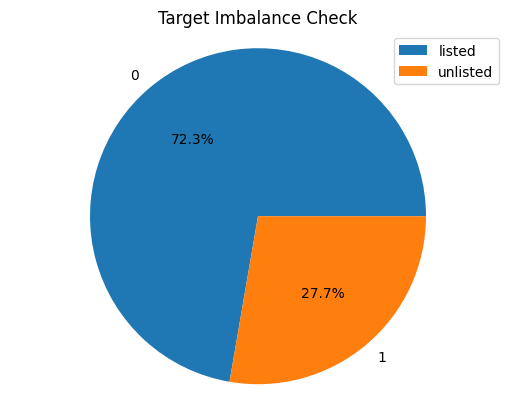

In [ ]:
# check for imbalance
# Count the number of instances for each target value
target_counts = dataframe[target_feature].value_counts()

# Create a pie chart
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Target Imbalance Check')
plt.legend(labels=['listed', 'unlisted'])
plt.show()

### 1.2.2 EDA Plots

In [ ]:
df_eda_tokens = train_eda[['description', 'description_regex', 'host_about', 'host_about_regex']].set_index(train.index)

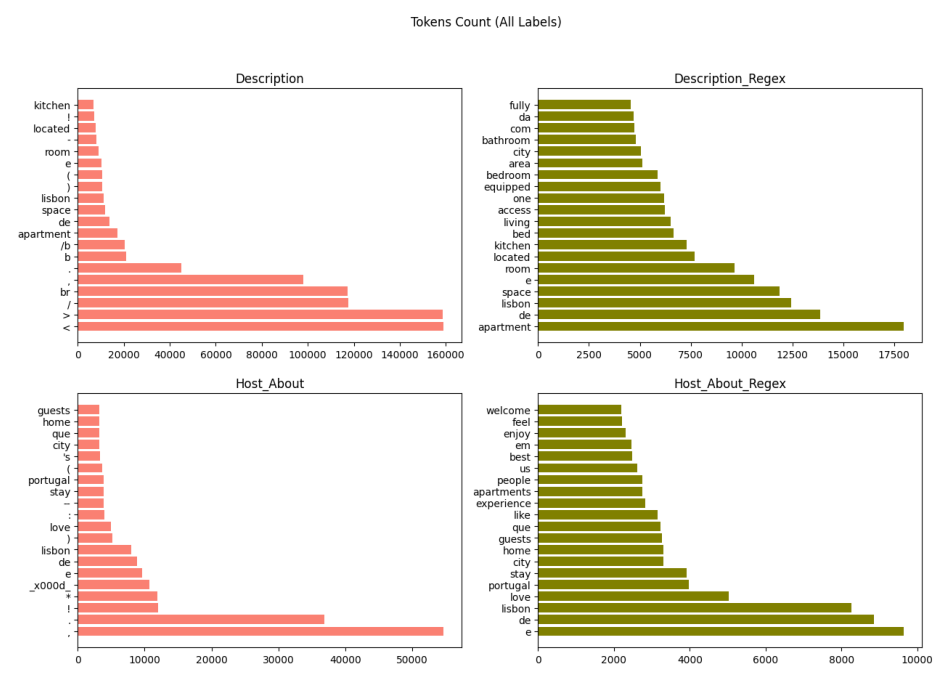

In [ ]:
plot_most_frequent_tokens(df_eda_tokens, n=20, label_filter='all')

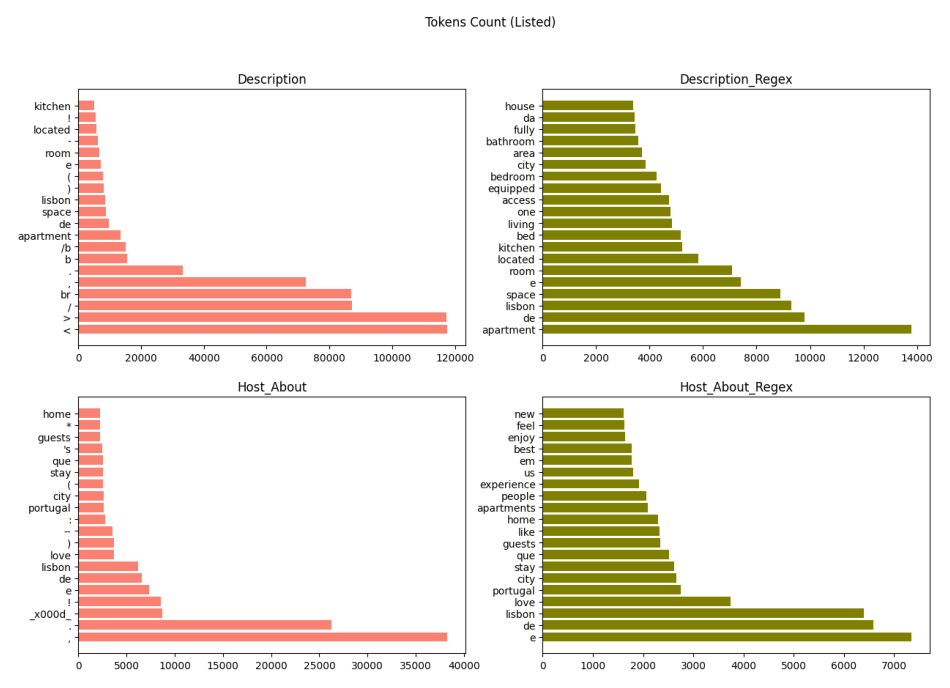

In [ ]:
plot_most_frequent_tokens(df_eda_tokens, n=20, label_filter='listed')

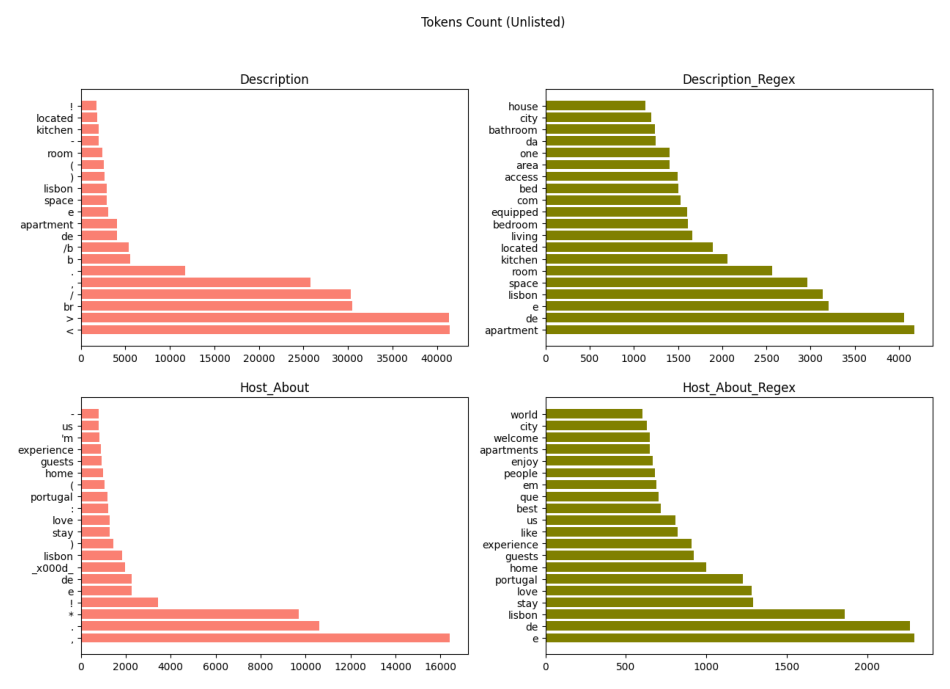

In [ ]:
plot_most_frequent_tokens(df_eda_tokens, n=20, label_filter='unlisted')

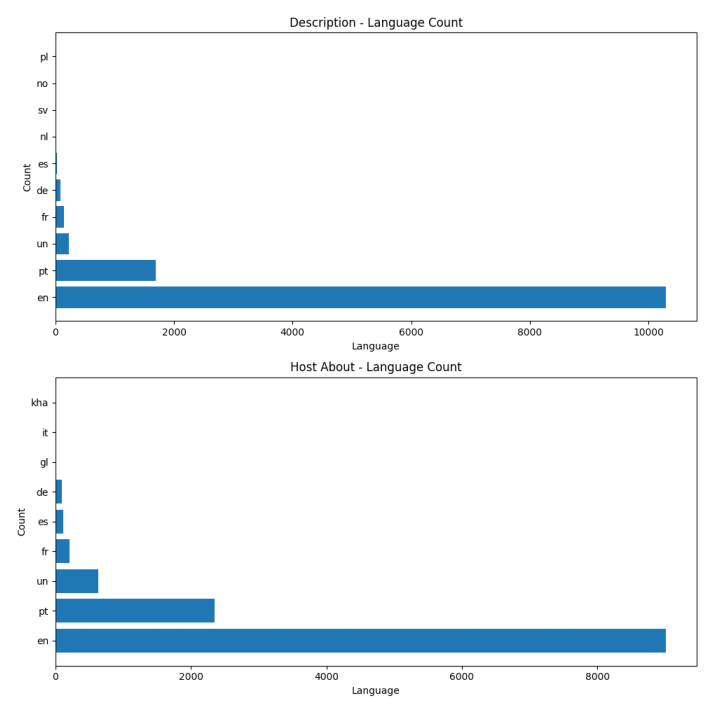

In [ ]:
language_count(train_eda[['description_lang', 'host_about_lang']])

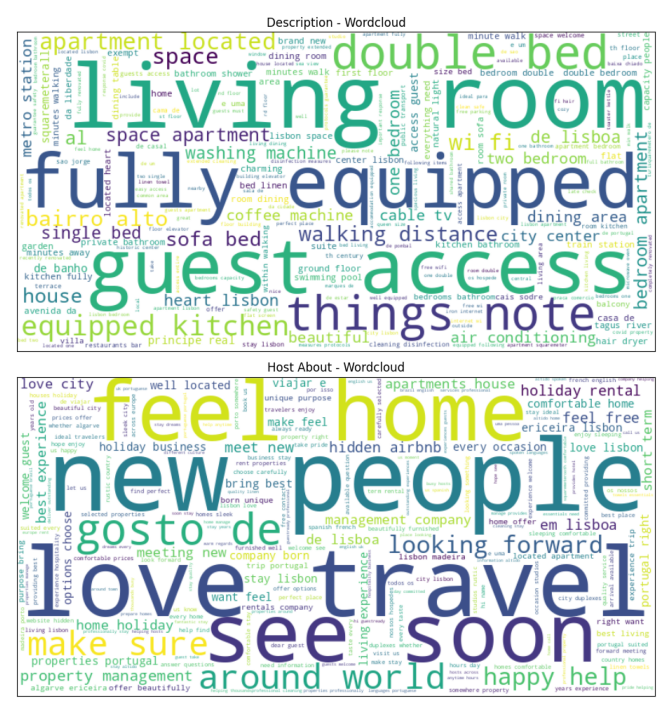

In [ ]:
word_clouds(train_eda[['description_regex', 'host_about_regex']])

## 1.3 train_reviews.xlsx

### 1.3.1 Basic EDA

In [ ]:
# define dataframe variable
dataframe = train_reviews.copy()
dataframe = dataframe.reset_index()

In [ ]:
# display head & tail
dataframe

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."
...,...,...
721397,12494,"We had a good time, the apartment has a great ..."
721398,12494,Great apartment in very central location. The ...
721399,12494,"We are Airbnb Super Hosts too, so trust me, Li..."
721400,12494,We had a lovely stay at this apartment. Sofia ...


In [ ]:
# data types
print('Data Types:', '\n')
dataframe.dtypes

Data Types: 



index        int64
comments    object
dtype: object

In [ ]:
# missing values
print('Missing Values:', '\n')
pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['Nulls','Empty Strings'], axis=1)

Missing Values: 



,Nulls,Empty Strings
index,0,0
comments,0,0


In [ ]:
# duplicated rows
print('Duplicated Rows:', '\n')
dataframe.duplicated().sum()

Duplicated Rows: 



305

### 1.3.2 EDA Plots

In [ ]:
df_eda = train_reviews_eda[['comments', 'comments_regex']]

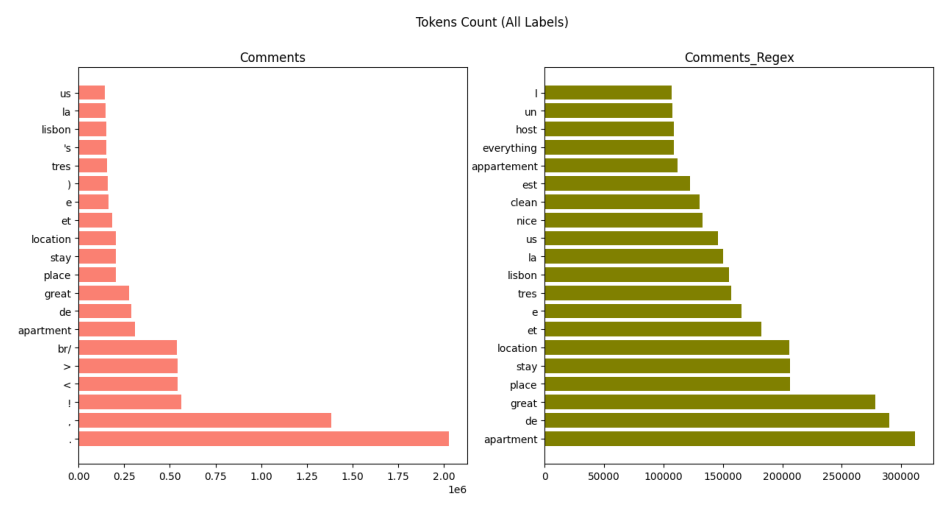

In [ ]:
plot_most_frequent_tokens(df_eda, n=20, label_filter='all')

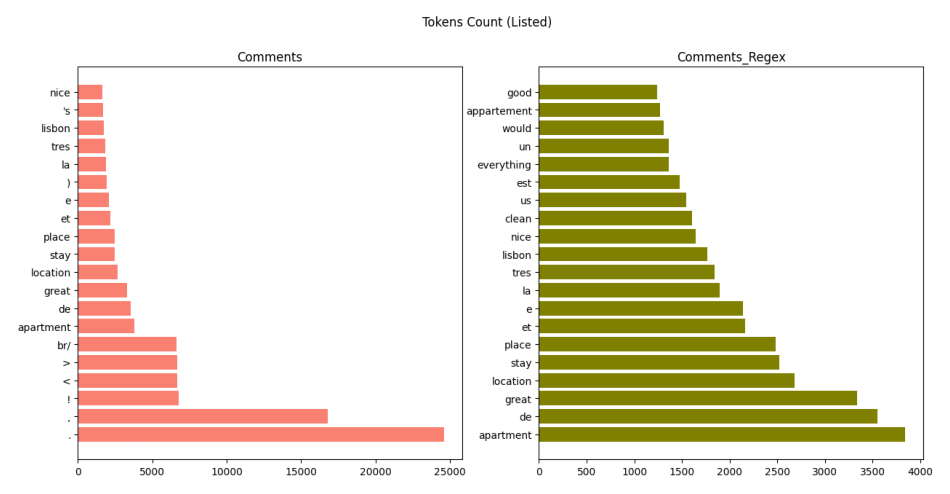

In [ ]:
plot_most_frequent_tokens(df_eda, n=20, label_filter='listed')

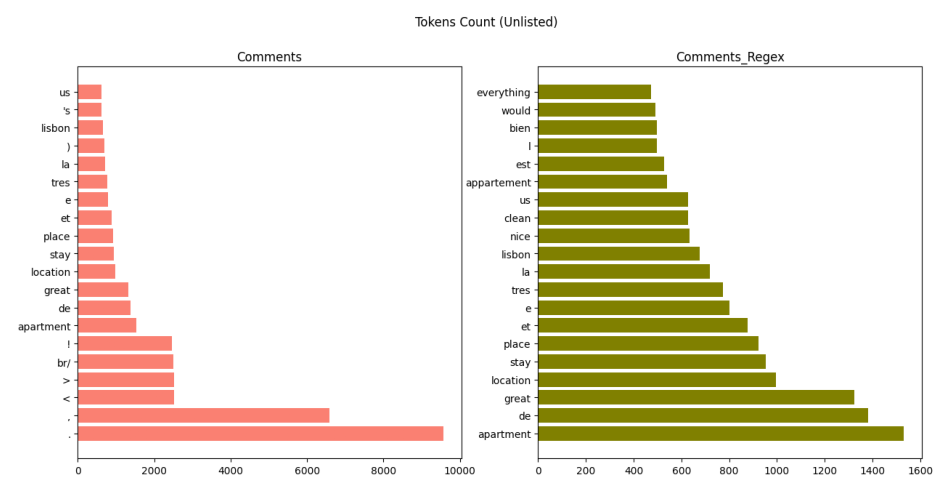

In [ ]:
plot_most_frequent_tokens(df_eda, n=20, label_filter='unlisted')

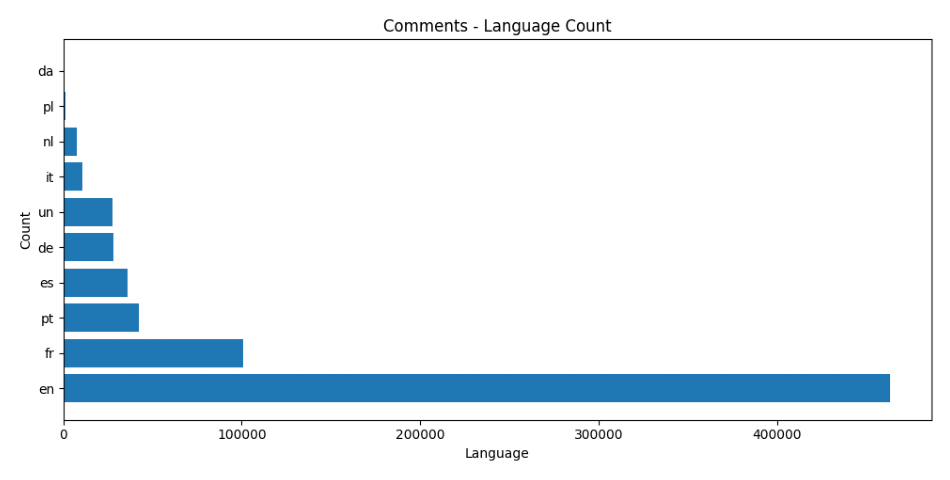

In [ ]:
language_count(train_reviews_eda[['comments_lang']])

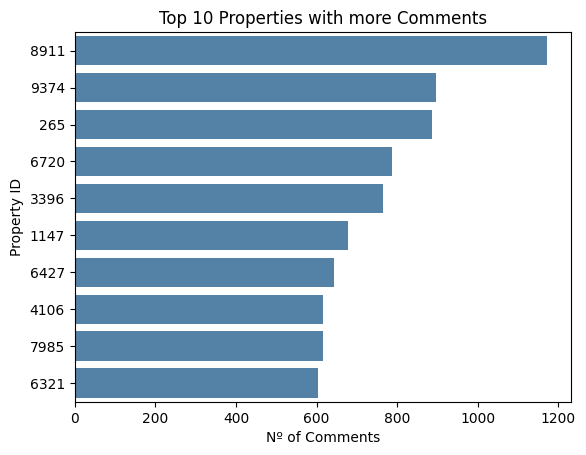

In [ ]:
nr_of_comments(train_reviews_eda)

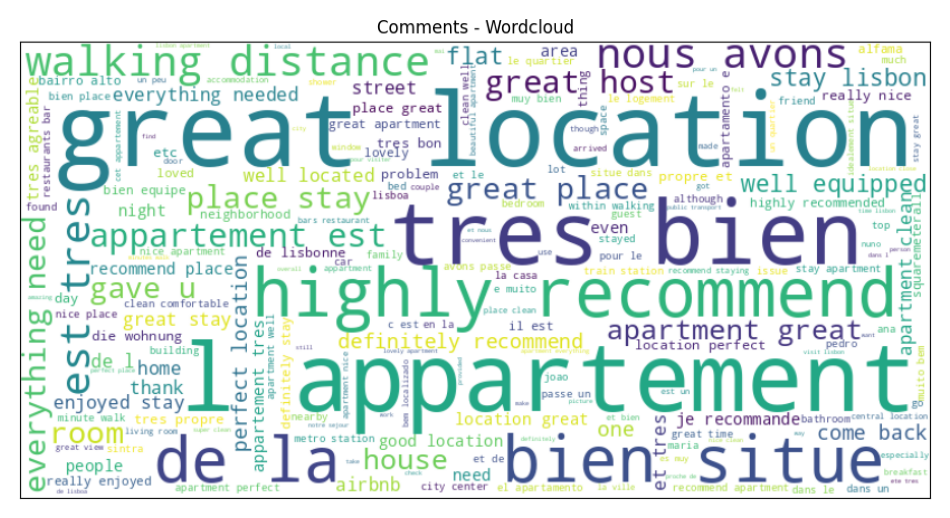

In [ ]:
word_clouds(train_reviews_eda[['comments_regex']].sample(50000, random_state=420))

# 2. Preprocessing


## 2.1 Regex Patterns

In [ ]:
regex_patterns = {
    # manually identified patterns
    r'_x005f_x000d_':               ' ',
    r'_x000d_':                     ' ',
    r'm2':                          'squaremeter',
    r'sm':                          'squaremeter',
    r'sqm':                         'squaremeter',
    r'm²':                          'squaremeter',
    r'license[ number]+[0-9a-z]+':  ' ',
    r'(\\b\\w)\\1+\\b':             ' ',

    # basic patterns
    # remove url
    r'http\S+':                     ' ',
    # remove html tags
    r'<.*?>':                       ' ',
    # remove punctuation
    r'[^\w\s]':                     ' ',
    # remove numbers
    r'\d+':                         ' ',
    # remove multiple whitespace
    r'\s+':                         ' ',
    # remove newline
    r'\n':                          ' '
}

regex_patterns_bert = {
    # manually identified patterns
    r'_x005f_x000d_':               ' ',
    r'_x000d_':                     ' ',
    r'm2':                          'squaremeter',
    r'sm':                          'squaremeter',
    r'sqm':                         'squaremeter',
    r'm²':                          'squaremeter',
    r'license[ number]+[0-9a-z]+':  ' ',
    r'(\\b\\w)\\1+\\b':             ' ',

    # basic patterns
    # remove url
    r'http\S+':                     ' ',
    # remove html tags
    r'<.*?>':                       ' ',
    # remove punctuation
    r'[^\w\s!,.;?]':                ' ',
    # remove numbers
    r'\d+':                         ' ',
    # remove multiple whitespace
    r'\s+':                         ' ',
    # remove _x
    r'_x\s':                        ' ',
    # remove second sign !.
    r'([.!?,:;])\s*([.!?,:;])+':    r'\1',
    # insert space after dot if not
    r'(?<=[.?!])(?=[^\s])':         ' '
}

## 2.2. Standard Pipeline

In [ ]:
def text_preprocessing(dataframe):
  '''
  Preprocessing Pipeline
  Input: dataframe
  Output: transformed dataframe
  '''

  categorical_features = list(dataframe.select_dtypes(exclude = np.number).columns)
  stop_words = set(stopwords.words('english'))
  lemmatizer = nltk.stem.WordNetLemmatizer()
  stemmers = {
    'es': nltk.stem.SnowballStemmer('spanish'),
    'pt': nltk.stem.SnowballStemmer('portuguese'),
    'nl': nltk.stem.SnowballStemmer('dutch'),
    'de': nltk.stem.SnowballStemmer('german'),
    'it': nltk.stem.SnowballStemmer('italian'),
    'da': nltk.stem.SnowballStemmer('danish'),
    'nb': nltk.stem.SnowballStemmer('norwegian'),
    'fi': nltk.stem.SnowballStemmer('finnish'),
    'sv': nltk.stem.SnowballStemmer('swedish')
  }

  # lowercase non-numeric features and convert to ASCII using unidecode
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: unidecode(x.lower()) if type(x) == str else '')

  # drop duplicates
  dataframe = dataframe.reset_index()
  dataframe = dataframe.drop_duplicates()

  # fill empty cells
  for col in categorical_features:
    dataframe[col] = dataframe[col].fillna('')

  # re.sub regex patterns (dictionary defined in the cell above)
  for col in categorical_features:
    for key, value in regex_patterns.items():
      dataframe[col] = dataframe[col].apply(lambda x: re.sub(key,value,x))

  # detect language
  for col in categorical_features:
    new_col = col + '_lang'
    dataframe[new_col] = dataframe[col].apply(lambda x: cld2.detect(x)[-1][0][1] if len(x) < 5000 else 'text has more than 5k characters')

  # tokenize and remove stopwords
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

  # part-of-speech tagging (english only)
  for col in categorical_features:
    lang_col = col + '_lang'
    dataframe[col] = dataframe.apply(lambda row: nltk.pos_tag(row[col]) if row[lang_col] == 'en' else row[col], axis=1)
    # wordnet mapping
    pos_tag_map = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV
    }

    dataframe[col] = dataframe.apply(lambda row: [(word, pos_tag_map.get(tag[0])) for word, tag in row[col]] if row[lang_col] == 'en' else row[col], axis=1)

  # lemmatizing (english only)
  for col in categorical_features:
    lang_col = col + '_lang'
    dataframe[col] = dataframe.apply(lambda row: [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in row[col]] if row[lang_col] == 'en' else row[col], axis=1)

  # stemming (non-english contained in the stemmers dictionary)
  for col in categorical_features:
    lang_col = col + '_lang'
    dataframe[col] = dataframe.apply(lambda row: [stemmers.get(row[lang_col]).stem(word) if row[lang_col] in stemmers.keys() else word for word in row[col]] if row[lang_col] != 'en' else row[col], axis=1)

  # combine again
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: ' '.join(x))

  # airbnb id to index
  dataframe = dataframe.set_index('index')

  return dataframe

## 2.3 Bert Pipeline

In [ ]:
def text_preprocessing_bert(column, method='random', num_sentences=30):
    '''
    Preprocessing Pipeline for BERT
    Input: column, method, num_sentences
    Output: transformed column
    '''

    stop_words = set(stopwords.words('english'))
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stemmers = {
        'es': nltk.stem.SnowballStemmer('spanish'),
        'pt': nltk.stem.SnowballStemmer('portuguese'),
        'nl': nltk.stem.SnowballStemmer('dutch'),
        'de': nltk.stem.SnowballStemmer('german'),
        'it': nltk.stem.SnowballStemmer('italian'),
        'da': nltk.stem.SnowballStemmer('danish'),
        'nb': nltk.stem.SnowballStemmer('norwegian'),
        'fi': nltk.stem.SnowballStemmer('finnish'),
        'sv': nltk.stem.SnowballStemmer('swedish')
    }

    # lowercase and convert to ASCII using unidecode
    column = column.apply(lambda x: unidecode(x.lower()) if type(x) == str else '')

    # fill empty cells
    column = column.fillna('')

    # re.sub regex patterns (dictionary defined in the cell above)
    for key, value in regex_patterns_bert.items():
        column = column.apply(lambda x: re.sub(key,value,x))

    # detect language
    language_lookup = column.apply(lambda x: cld2.detect(x)[-1][0][1] if len(x) < 5000 else 'text has more than 5k characters')

    # create column & language datframe
    lang_df = pd.DataFrame({'Column': column, 'Language': language_lookup})

    # tokenize and remove stopwords
    lang_df['Column'] = lang_df.apply(lambda row: [word for word in word_tokenize(row['Column']) if word not in stop_words], axis=1)

    # part-of-speech tagging (english only)
    lang_df['Column'] = lang_df.apply(lambda row: nltk.pos_tag(row['Column']) if row['Language'] == 'en' else row['Column'], axis=1)
    # wordnet mapping
    pos_tag_map = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }

    lang_df['Column'] = lang_df.apply(lambda row: [(word, pos_tag_map.get(tag[0])) for word, tag in row['Column']] if row['Language'] == 'en' else row['Column'], axis=1)

    # lemmatizing if cell language is english
    lang_df['Column'] = lang_df.apply(lambda row: [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in row['Column']] if row['Language'] == 'en' else row['Column'], axis=1)

    # stemming (non-english contained in the stemmers dictionary)
    lang_df['Column'] = lang_df.apply(lambda row: [stemmers.get(row['Language']).stem(word) if row['Language'] in stemmers.keys() else word for word in row['Column']] if row['Language'] != 'en' else row['Column'], axis=1)

    # combine tokens again with punctuation
    column = lang_df['Column'].apply(lambda x: re.sub(r'\s([?.!,:;])', r'\1', ' '.join(x)))

    # split cell content into sentences
    column = column.apply(lambda x: sent_tokenize(x))
    # random sentence selection
    if method == 'random':
        column = column.apply(lambda x: random.sample(x, num_sentences) if len(x) > num_sentences else x)
    # select first n sentences
    elif method == 'first_n':
        column = column.apply(lambda x: x[:num_sentences] if len(x) > num_sentences else x)

    return column

## 2.4 Apply Preprocessing (Standard)

In [ ]:
# train dataset copy
train_preprocessed = train.copy()

# apply preprocessing function
train_preprocessed = text_preprocessing(train_preprocessed)

In [ ]:
train_preprocessed.head(3)

,description,host_about,unlisted,description_lang,host_about_lang
index,,,,,
1,share mixed room hostel share bathroom locate ...,alojamento local registro al,0,en,en
2,meu espac fic pert de parqu eduard vii saldanh...,friendly host try always around need anything ...,1,pt,en
3,trafaria house cozy familiar villa facility ne...,social person like communicate read travel lik...,1,en,en


In [ ]:
# train_reviews dataset copy
train_reviews_preprocessed = train_reviews.copy()

# apply preprocessing function
train_reviews_preprocessed = text_preprocessing(train_reviews_preprocessed)

In [ ]:
train_reviews_preprocessed.head(3)

,comments,comments_lang
index,,
1,cozy comfortable house stay never worry safety...,en
1,good,un
1,first hostel experience say pretty hard beat p...,en


## 2.5 Apply Preprocessing (Bert)

In [ ]:
# train dataset copy
train_preprocessed_bert = train.copy()

# apply preprocessing function
train_preprocessed_bert['description'] = text_preprocessing_bert(column=train_preprocessed_bert['description'], method='first_n', num_sentences=30)
train_preprocessed_bert['host_about'] = text_preprocessing_bert(column=train_preprocessed_bert['host_about'], method='first_n', num_sentences=30)

In [ ]:
train_preprocessed_bert.head(3)

,description,host_about,unlisted
index,,,
1,"[share mixed room hostel, share bathroom., loc...",[alojamento local registro al],0
2,"[meu espac fic pert de parqu eduard vii, salda...","[friendly host, try always around need anythin...",1
3,[trafaria house cozy familiar villa facility n...,"[social person like communicate, read travel.,...",1


In [ ]:
# train_reviews dataset copy
train_reviews_preprocessed_bert = train_reviews.copy()

# group text by airbnb id
train_reviews_preprocessed_bert = pd.DataFrame(train_reviews_preprocessed_bert.groupby(level=0)['comments'].agg(lambda x: ' '.join(map(str, x))))

# apply preprocessing function
train_reviews_preprocessed_bert = pd.DataFrame(text_preprocessing_bert(column=train_reviews_preprocessed_bert['comments'], method='random', num_sentences=30)).rename(columns={'Column':'comments'})

In [ ]:
train_reviews_preprocessed_bert.head(3)

,comments
index,
1,"[fantastic place, felt home!, place nice., bed..."
5,"[alojamiento recomendable., wir waren sehr gut..."
8,"[host great moment made reservation end trip.,..."


# 3. Feature Engineering

- Sentiment Analysis on Comments

In [ ]:
def sentiment_analysis(dataframe, column='comments', language_column='comments_lang'):
    '''
    Sentiment analysis using vaderSentiment
    Input: dataframe
    Output: dataframe with sentiment columns
    '''
    new_column = column + '_sentiment'
    sia = SentimentIntensityAnalyzer()

    # calculate sentiment
    dataframe[new_column] = dataframe[column].apply(lambda x: sia.polarity_scores(x))
    # create column to store compound score
    dataframe['compound'] = dataframe[new_column].apply(lambda x: x['compound'])
    # get most likely label (neutral, positive, negative)
    dataframe[new_column] = dataframe[new_column].apply(lambda x: {key:val for key,val in x.items() if key != 'compound'})
    dataframe[new_column] = dataframe[new_column].apply(lambda x: max(x, key=x.get))
    # set empty string comments from 'neg' (negative) to 'neu' (neutral)
    dataframe[new_column] = ['neu' if y == '' else x for x,y in zip(dataframe[new_column], dataframe[column])]
    # exception for comments which are not in english
    dataframe[new_column] = ['neu' if y != 'en' else x for x,y in zip(dataframe[new_column], dataframe[language_column])]

    # group by index and get average compound score
    grouped_df = dataframe.groupby(level=0).agg({'compound': 'mean'}).rename(columns={'compound':'avg_compound'})

    # number of comments
    grouped_df['num_comments'] = dataframe.groupby(level=0).agg({'compound': 'count'})

    # number of positive comments
    pos_df = dataframe[dataframe[new_column] == 'pos'].groupby(level=0).agg({'compound': 'count'}).rename(columns={'compound':'num_pos'})
    grouped_df = grouped_df.merge(pos_df, how='left', left_index=True, right_index=True).fillna(0)

    # number of negative comments
    neg_df = dataframe[dataframe[new_column] == 'neg'].groupby(level=0).agg({'compound': 'count'}).rename(columns={'compound':'num_neg'})
    grouped_df = grouped_df.merge(neg_df, how='left', left_index=True, right_index=True).fillna(0)

    # number of neutral comments
    neu_df = dataframe[dataframe[new_column] == 'neu'].groupby(level=0).agg({'compound': 'count'}).rename(columns={'compound':'num_neu'})
    grouped_df = grouped_df.merge(neu_df, how='left', left_index=True, right_index=True).fillna(0)

    # add text
    grouped_df['comments'] = dataframe.groupby(level=0).agg({'comments': ' '.join})

    return grouped_df

In [ ]:
train_reviews_sentiment = train_reviews_preprocessed.copy()
train_reviews_sentiment = sentiment_analysis(train_reviews_sentiment)

In [ ]:
train_reviews_sentiment.head(3)

,avg_compound,num_comments,num_pos,num_neg,num_neu,comments
index,,,,,,
1,0.350856,50,13.0,0.0,37,cozy comfortable house stay never worry safety...
5,0.356895,41,10.0,0.0,31,un tres bel appartement avec une magnifique vu...
8,0.793790,168,71.0,0.0,97,shani helpful throughout process thank answer ...


# 4. Combine Data

## 4.1 Standard Dataset

In [ ]:
# re-order columns
train_df = train_preprocessed[['unlisted', 'description', 'host_about']]
train_reviews_df = train_reviews_sentiment[['comments', 'avg_compound', 'num_comments', 'num_pos', 'num_neg', 'num_neu']]

# merge train and train-reviews datasets
combined_standard_preprocessing = pd.merge(train_df, train_reviews_df, left_index=True, right_index=True, how='left')

# get numeric/non-numeric columns
numeric_cols = combined_standard_preprocessing.select_dtypes(include=np.number).columns.tolist()
non_numeric_cols = combined_standard_preprocessing.select_dtypes(exclude=np.number).columns.tolist()
# fillna for numeric columns
combined_standard_preprocessing[numeric_cols] = combined_standard_preprocessing[numeric_cols].fillna(0)
# fillna for non-numeric columns
combined_standard_preprocessing[non_numeric_cols] = combined_standard_preprocessing[non_numeric_cols].fillna('')

In [ ]:
combined_standard_preprocessing.head(3)

,unlisted,description,host_about,comments,avg_compound,num_comments,num_pos,num_neg,num_neu
index,,,,,,,,,
1,0,share mixed room hostel share bathroom locate ...,alojamento local registro al,cozy comfortable house stay never worry safety...,0.350856,50.0,13.0,0.0,37.0
2,1,meu espac fic pert de parqu eduard vii saldanh...,friendly host try always around need anything ...,,0.000000,0.0,0.0,0.0,0.0
3,1,trafaria house cozy familiar villa facility ne...,social person like communicate read travel lik...,,0.000000,0.0,0.0,0.0,0.0


## 4.2 Bert Dataset

In [ ]:
# re-order columns
train_df_bert = train_preprocessed_bert[['unlisted', 'description', 'host_about']]
train_reviews_df_bert = train_reviews_preprocessed_bert
train_reviews_sentiment_df_bert = train_reviews_sentiment[['avg_compound', 'num_comments', 'num_pos', 'num_neg', 'num_neu']]

combined_bert_preprocessing = pd.merge(train_df_bert, train_reviews_df_bert, left_index=True, right_index=True, how='left')
combined_bert_preprocessing = pd.merge(combined_bert_preprocessing, train_reviews_sentiment_df_bert, left_index=True, right_index=True, how='left')

# get numeric/non-numeric columns
numeric_cols = combined_bert_preprocessing.select_dtypes(include=np.number).columns.tolist()
non_numeric_cols = combined_bert_preprocessing.select_dtypes(exclude=np.number).columns.tolist()
# fillna for numeric columns
combined_bert_preprocessing[numeric_cols] = combined_bert_preprocessing[numeric_cols].fillna(0)
# fillna for non-numeric columns
combined_bert_preprocessing[non_numeric_cols] = combined_bert_preprocessing[non_numeric_cols].fillna('')

In [ ]:
combined_bert_preprocessing.head(3)

,unlisted,description,host_about,comments,avg_compound,num_comments,num_pos,num_neg,num_neu
index,,,,,,,,,
1,0,"[share mixed room hostel, share bathroom., loc...",[alojamento local registro al],"[fantastic place, felt home!, place nice., bed...",0.350856,50.0,13.0,0.0,37.0
2,1,"[meu espac fic pert de parqu eduard vii, salda...","[friendly host, try always around need anythin...",,0.000000,0.0,0.0,0.0,0.0
3,1,[trafaria house cozy familiar villa facility n...,"[social person like communicate, read travel.,...",,0.000000,0.0,0.0,0.0,0.0


# 5. Train-Test Split

## 5.1 Standard Dataset

In [ ]:
# combined standard preprocessing

x, y = combined_standard_preprocessing.drop(columns=['unlisted']), combined_standard_preprocessing['unlisted']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=420)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, stratify=ytrain, random_state=420)

## 5.2 Bert Dataset

In [ ]:
# combined bert preprocessing

x_bert, y_bert = combined_bert_preprocessing.drop(columns=['unlisted']), combined_bert_preprocessing['unlisted']

xtrain_bert, ytrain_bert = x_bert.loc[xtrain.index], y_bert.loc[xtrain.index]
xval_bert, yval_bert = x_bert.loc[xval.index], y_bert.loc[xval.index]
xtest_bert, ytest_bert = x_bert.loc[xtest.index], y_bert.loc[xtest.index]

# 6. Vectorization/Embeddings

## 6.1 Function - Save Vectorization/Embeddings Data

In [ ]:
def save_data(xtrain, xval, xtest, ytrain, yval, ytest, path_to_folder):
  # make directory
  os.makedirs('path_to_folder', exist_ok=True)
  # train/val/test split inidicator
  xtrain['dataset'], xval['dataset'], xtest['dataset'] = 'xtrain', 'xval', 'xtest'
  # add labels
  xtrain['label'], xval['label'], xtest['label'] = ytrain.values, yval.values, ytest.values
  # concat dataframe
  data = pd.concat([xtrain, xval, xtest], axis=0)
  # save to folder
  save_to = f'{path_to_folder}/data.csv'
  data.to_csv(save_to)
  return print(f'Data saved at: {save_to}')

## 6.2 Bag-of-Words

In [ ]:
def bow_encoder(xtrain=xtrain, xval=xval, xtest=xtest, max_features=1000):
  '''
  Encodes the text data using bag-of-words
  Input: xtrain, xval, xtest, max_features (optional)
  Output: transformed dataframe with Bag-of-Words applied column wise
  '''

  # exclude feature engineering
  xtrain, xtrain_fe = xtrain.iloc[:, :-5], xtrain.iloc[:, -5:]
  xval, xval_fe = xval.iloc[:, :-5], xval.iloc[:, -5:]
  xtest, xtest_fe = xtest.iloc[:, :-5], xtest.iloc[:, -5:]

  for col in xtrain.columns:
    # initialize CountVectorizer
    bow = CountVectorizer(max_features=max_features)
    # fit CountVectorizer
    bow.fit(xtrain[col])
    # transform xtrain, xval, xtest column
    xtrain[col] = xtrain[col].apply(lambda x: list(bow.transform([x]).toarray().reshape(-1)))
    xval[col] = xval[col].apply(lambda x: list(bow.transform([x]).toarray().reshape(-1)))
    xtest[col] = xtest[col].apply(lambda x: list(bow.transform([x]).toarray().reshape(-1)))

  # merge with feature engineering columns again
  xtrain = pd.merge(xtrain, xtrain_fe, left_index=True, right_index=True, how='left')
  xval = pd.merge(xval, xval_fe, left_index=True, right_index=True, how='left')
  xtest = pd.merge(xtest, xtest_fe, left_index=True, right_index=True, how='left')

  return xtrain, xval, xtest

In [ ]:
# bag-of-words (standard preprocessing)

xtrain_bow, xval_bow, xtest_bow = bow_encoder(xtrain=xtrain, xval=xval, xtest=xtest)

In [ ]:
# save to folder

save_data(xtrain=xtrain_bow, xval=xval_bow, xtest=xtest_bow, ytrain=ytrain, yval=yval, ytest=ytest, path_to_folder='Data/BagOfWords')

## 6.3 TF-IDF

In [ ]:
def tfidf_encoder(xtrain=xtrain, xval=xval, xtest=xtest, max_features=1000):
  '''
  Encodes the text data using TF-IDF
  Input: xtrain, xval, xtest, max_features (optional)
  Output: transformed dataframe with TF-IDF applied column wise
  '''

  # exclude feature engineering
  xtrain, xtrain_fe = xtrain.iloc[:, :-5], xtrain.iloc[:, -5:]
  xval, xval_fe = xval.iloc[:, :-5], xval.iloc[:, -5:]
  xtest, xtest_fe = xtest.iloc[:, :-5], xtest.iloc[:, -5:]

  for col in xtrain.columns:
    # initialize tfidf vectorizer
    tfidf = TfidfVectorizer(max_features=max_features)
    # fit TfidfVectorizer
    tfidf.fit(xtrain[col])
    # transform xtrain, xval, xtest column
    xtrain[col] = xtrain[col].apply(lambda x: list(tfidf.transform([x]).toarray().reshape(-1)))
    xval[col] = xval[col].apply(lambda x: list(tfidf.transform([x]).toarray().reshape(-1)))
    xtest[col] = xtest[col].apply(lambda x: list(tfidf.transform([x]).toarray().reshape(-1)))

  # merge with feature engineering columns again
  xtrain = pd.merge(xtrain, xtrain_fe, left_index=True, right_index=True, how='left')
  xval = pd.merge(xval, xval_fe, left_index=True, right_index=True, how='left')
  xtest = pd.merge(xtest, xtest_fe, left_index=True, right_index=True, how='left')

  return xtrain, xval, xtest

In [ ]:
# TF-IDF (standard preprocessing)

xtrain_tfidf, xval_tfidf, xtest_tfidf = tfidf_encoder(xtrain=xtrain, xval=xval, xtest=xtest)

In [ ]:
# save to folder

save_data(xtrain=xtrain_tfidf, xval=xval_tfidf, xtest=xtest_tfidf, ytrain=ytrain, yval=yval, ytest=ytest, path_to_folder='Data/TFIDF')

## 6.4 Skip-Gram

In [ ]:
def skipgram_encoder(xtrain, xval, xtest, vector_size=100, window=5, min_count=1):
    """
    Encodes the text data using skip-gram vectorization
    Input: xtrain, xval, xtest, vector_size (optional), window (optional), min_count (optional)
    Output: transformed dataframe with skip-gram vectors applied column-wise
    """

    # Exclude feature engineering
    xtrain, xtrain_fe = xtrain.iloc[:, :-5], xtrain.iloc[:, -5:]
    xval, xval_fe = xval.iloc[:, :-5], xval.iloc[:, -5:]
    xtest, xtest_fe = xtest.iloc[:, :-5], xtest.iloc[:, -5:]

    for col in xtrain.columns:
        # Train Word2Vec model on the column data
        sentences = xtrain[col].apply(lambda x: x.split())
        model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, sg=1)

        # Transform xtrain, xval, xtest column
        xtrain[col] = xtrain[col].apply(lambda x: np.mean([model.wv[word] for word in x.split() if word in model.wv], axis=0))
        xval[col] = xval[col].apply(lambda x: np.mean([model.wv[word] for word in x.split() if word in model.wv], axis=0))
        xtest[col] = xtest[col].apply(lambda x: np.mean([model.wv[word] for word in x.split() if word in model.wv], axis=0))

        # Fill empty cells and convert to python list
        xtrain[col] = xtrain[col].apply(lambda x: list(np.zeros(vector_size)) if isinstance(x, float) and pd.isnull(x) else list(x))
        xval[col] = xval[col].apply(lambda x: list(np.zeros(vector_size)) if isinstance(x, float) and pd.isnull(x) else list(x))
        xtest[col] = xtest[col].apply(lambda x: list(np.zeros(vector_size)) if isinstance(x, float) and pd.isnull(x) else list(x))

    # Merge with feature engineering columns again
    xtrain = pd.merge(xtrain, xtrain_fe, left_index=True, right_index=True, how='left')
    xval = pd.merge(xval, xval_fe, left_index=True, right_index=True, how='left')
    xtest = pd.merge(xtest, xtest_fe, left_index=True, right_index=True, how='left')

    return xtrain, xval, xtest

In [ ]:
# Skip-Grams (standard preprocessing)

xtrain_skip, xval_skip, xtest_skip = skipgram_encoder(xtrain=xtrain, xval=xval, xtest=xtest)

In [ ]:
# save to folder

save_data(xtrain=xtrain_skip, xval=xval_skip, xtest=xtest_skip, ytrain=ytrain, yval=yval, ytest=ytest, path_to_folder='Data/SkipGrams')

## 6.5 Word Embeddings (BERT)

In [ ]:
def bert_word_embeddings(xtrain=xtrain, xval=xval, xtest=xtest):

    # exclude feature engineering
    xtrain, xtrain_fe = xtrain.iloc[:, :-5], xtrain.iloc[:, -5:]
    xval, xval_fe = xval.iloc[:, :-5], xval.iloc[:, -5:]
    xtest, xtest_fe = xtest.iloc[:, :-5], xtest.iloc[:, -5:]

    # load pre-trained BERT model and tokenizer
    model_name = 'distilbert-base-uncased'
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name)
    model.eval()

    # define function to convert sentence to BERT word embeddings
    def get_sentence_embeddings(sentence):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=512, padding='longest', truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze()
        return embeddings.numpy()

    # define function to transform dataframe
    def transform_dataframe(dataframe):
        for col in dataframe.columns:
          # replace empty strings with empty arrays
          dataframe[col] = dataframe[col].apply(lambda x: np.array([]) if isinstance(x, str) and x == '' else x)

          # convert sentences to BERT word embeddings
          dataframe[col] = dataframe[col].apply(lambda x: np.mean([get_sentence_embeddings(sentence) for sentence in x], axis=0))

          # Fill empty cells and convert to python list
          dataframe[col] = dataframe[col].apply(lambda x: list(np.zeros(len(get_sentence_embeddings(['sample'])))) if isinstance(x, float) and pd.isnull(x) else list(x))

        return dataframe

    # transform train, validation, and test dataframes
    xtrain = transform_dataframe(xtrain)
    xval = transform_dataframe(xval)
    xtest = transform_dataframe(xtest)

    # merge with feature engineering columns again
    xtrain = pd.merge(xtrain, xtrain_fe, left_index=True, right_index=True, how='left')
    xval = pd.merge(xval, xval_fe, left_index=True, right_index=True, how='left')
    xtest = pd.merge(xtest, xtest_fe, left_index=True, right_index=True, how='left')

    return xtrain, xval, xtest

In [ ]:
# BERT Word Embeddings (BERT preprocessing)

xtrain_embed, xval_embed, xtest_embed = bert_word_embeddings(xtrain=xtrain_bert, xval=xval_bert, xtest=xtest_bert)

In [ ]:
# save to folder

save_data(xtrain=xtrain_embed, xval=xval_embed, xtest=xtest_embed, ytrain=ytrain_bert, yval=yval_bert, ytest=ytest_bert, path_to_folder='Data/Bert')

# 7. Modelling

## 7.1 Load & Prepare Vectorization/Embeddings Data

In [ ]:
def load_data(path):
  # read csv
  data = pd.read_csv(path, index_col='index')

  # transform string to numpy
  data.iloc[:,:3] = data.iloc[:,:3].applymap(lambda x: np.array(ast.literal_eval(x)))

  # split again
  train = data[data['dataset']=='xtrain'].drop(columns=['dataset'])
  val = data[data['dataset']=='xval'].drop(columns=['dataset'])
  test = data[data['dataset']=='xtest'].drop(columns=['dataset'])

  return train, val, test

In [ ]:
# load bag-of-words
train_bow, val_bow, test_bow = load_data('Data/BagOfWords/data.csv')
# load tf-idf
train_tfidf, val_tfidf, test_tfidf = load_data('Data/TFIDF/data.csv')
# load skip-grams
train_skip, val_skip, test_skip = load_data('Data/SkipGrams/data.csv')
# load BERT embeddings
train_embed, val_embed, test_embed = load_data('Data/Bert/data.csv')

In [ ]:
def prepare_data(dataframe, smote=False):

  comments = np.vstack(dataframe['comments'].to_numpy())
  description = np.vstack(dataframe['description'].to_numpy())
  host_about = np.vstack(dataframe['host_about'].to_numpy())
  avg_compound = dataframe[['avg_compound']].to_numpy()
  num_comments = dataframe[['num_comments']].to_numpy()
  num_pos = dataframe[['num_pos']].to_numpy()
  num_neg = dataframe[['num_neg']].to_numpy()
  num_neu = dataframe[['num_neu']].to_numpy()

  x = np.hstack((comments, description, host_about, avg_compound, num_comments, num_pos, num_neg, num_neu))
  y = dataframe['label'].to_numpy()

  # SMOTE oversampling
  if smote:
    smote = SMOTE(random_state=420)
    x, y = smote.fit_resample(x, y)

  return x, y

In [ ]:
# prepare bag-of-words
xtrain_bow, ytrain_bow = prepare_data(train_bow, smote=True)
xval_bow, yval_bow = prepare_data(val_bow)
xtest_bow, ytest_bow = prepare_data(test_bow)

# prepare tf-idf
xtrain_tfidf, ytrain_tfidf = prepare_data(train_tfidf, smote=True)
xval_tfidf, yval_tfidf = prepare_data(val_tfidf)
xtest_tfidf, ytest_tfidf = prepare_data(test_tfidf)

# prepare skip-grams
xtrain_skip, ytrain_skip = prepare_data(train_skip, smote=True)
xval_skip, yval_skip = prepare_data(val_skip)
xtest_skip, ytest_skip = prepare_data(test_skip)

# prepare bert
xtrain_embed, ytrain_embed = prepare_data(train_embed, smote=True)
xval_embed, yval_embed = prepare_data(val_embed)
xtest_embed, ytest_embed = prepare_data(test_embed)

## 7.2 Modelling Functions

In [ ]:
def multiple_roc_auc(classifiers, xtrain, xval, ytrain, yval):
    '''
    Plots ROC/AUC curves for multiple classifiers.
    Input: classifiers (dict), xtrain, ytrain, xval, yval
    Output: ROC/AUC curves plot
    '''

    fig, ax = plt.subplots(1, figsize=(15, 10))
    for name, clf in classifiers.items():
        clf.fit(xtrain, ytrain)
        RocCurveDisplay.from_estimator(clf, xval, yval, ax=ax, name=name)
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.plot([0,1], [0,1], linestyle='--')
    return plt.show()

def evaluation(ytrue, ypred):
  d = {'Accuracy': None, 'Precision': None, 'Recall': None, 'F1-Score': None}

  d['Accuracy'] = accuracy_score(ytrue, ypred)
  d['Precision'] = precision_score(ytrue, ypred)
  d['Recall'] = recall_score(ytrue, ypred)
  d['F1-Score'] = f1_score(ytrue, ypred)

  # plot dataframe
  metrics = pd.Series(d)
  display(metrics)

  print('\n\n\n')

  # plot confusion matrix
  conf_matrix = confusion_matrix(ytrue, ypred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.show()

## 7.3 Scikit-Learn Models

### 7.3.1 ROC/AUC Curves

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


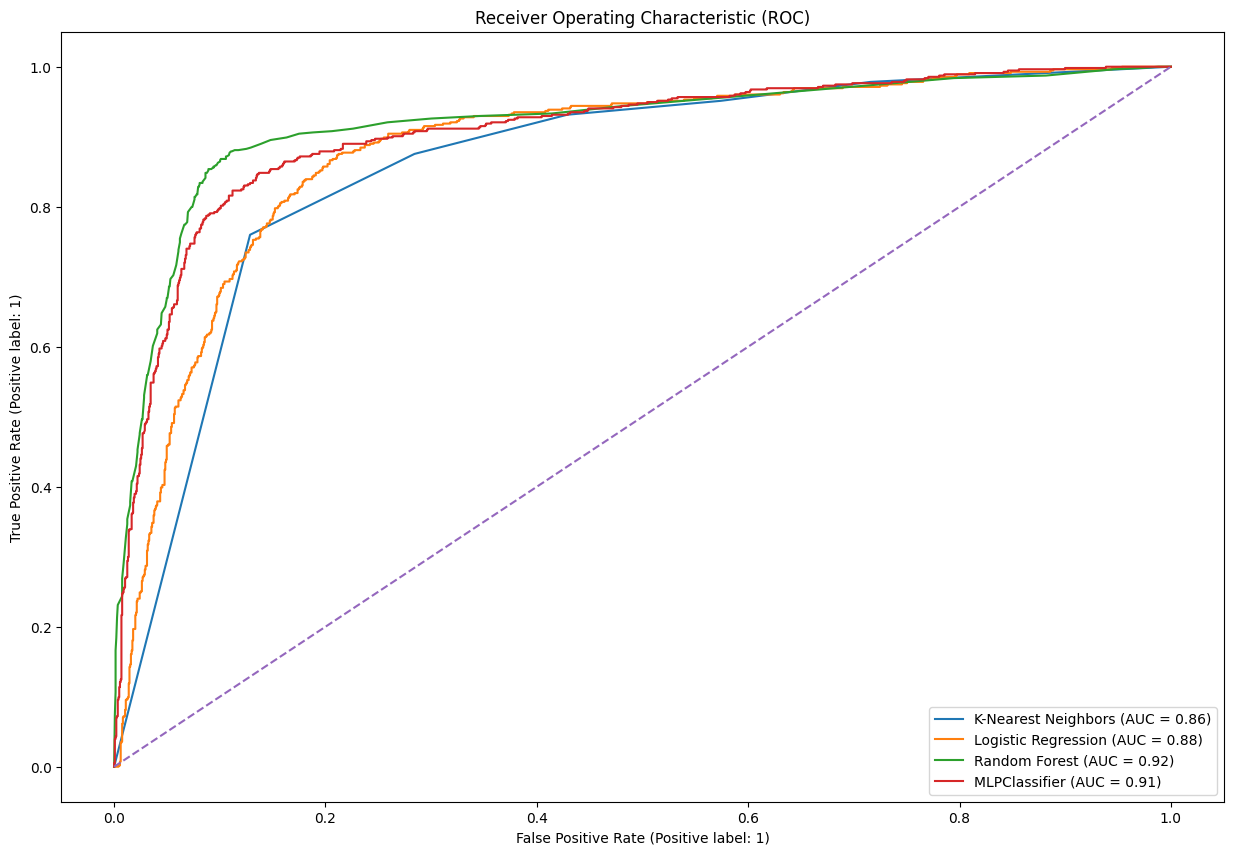

In [ ]:
# classifiers to check
classifiers = {
                'K-Nearest Neighbors': KNeighborsClassifier(),
                'Logistic Regression': LogisticRegression(),
                'Random Forest': RandomForestClassifier(),
                'MLPClassifier': MLPClassifier(early_stopping=True)
                }

multiple_roc_auc(classifiers, xtrain_bow, xval_bow, ytrain_bow, yval_bow)

### 7.3.2 K-Nearest-Neighbor

Accuracy     0.671000
Precision    0.454225
Recall       0.931408
F1-Score     0.610651
dtype: float64

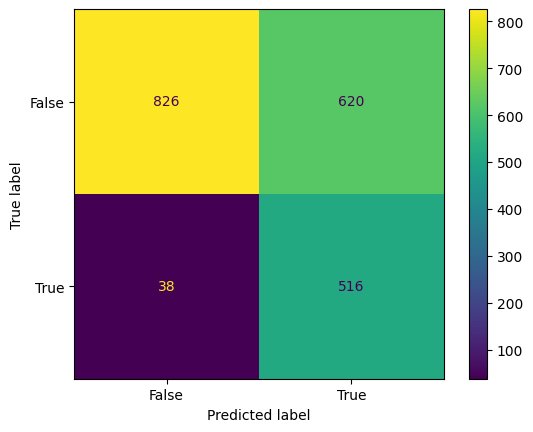

In [ ]:
# Bag-of-Words

knn = KNeighborsClassifier(n_jobs=-1)
# fit model on training data
knn.fit(xtrain_bow, ytrain_bow)
# make predictions on validation data
ypred = knn.predict(xval_bow)
# evaluation
evaluation(yval_bow, ypred)

Accuracy     0.796000
Precision    0.586085
Recall       0.897112
F1-Score     0.708987
dtype: float64

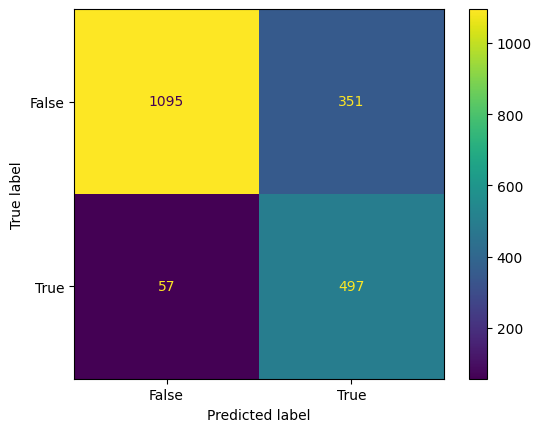

In [ ]:
# TF-IDF

knn = KNeighborsClassifier(n_jobs=-1)
# fit model on training data
knn.fit(xtrain_tfidf, ytrain_tfidf)
# make predictions on validation data
ypred = knn.predict(xval_tfidf)
# evaluation
evaluation(yval_tfidf, ypred)

Accuracy     0.840000
Precision    0.658537
Recall       0.877256
F1-Score     0.752322
dtype: float64

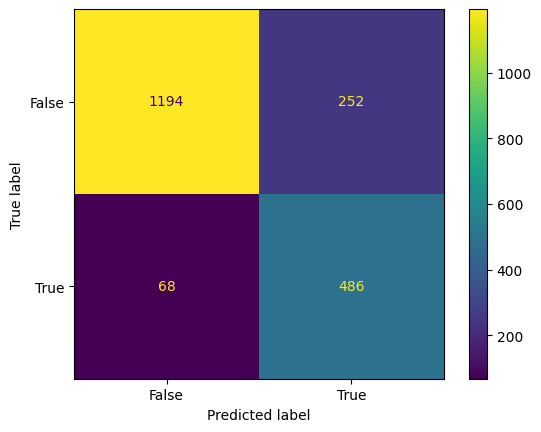

In [ ]:
# Skip-Grams

knn = KNeighborsClassifier(n_jobs=-1)
# fit model on training data
knn.fit(xtrain_skip, ytrain_skip)
# make predictions on validation data
ypred = knn.predict(xval_skip)
# evaluation
evaluation(yval_skip, ypred)

Accuracy     0.823000
Precision    0.629534
Recall       0.877256
F1-Score     0.733032
dtype: float64

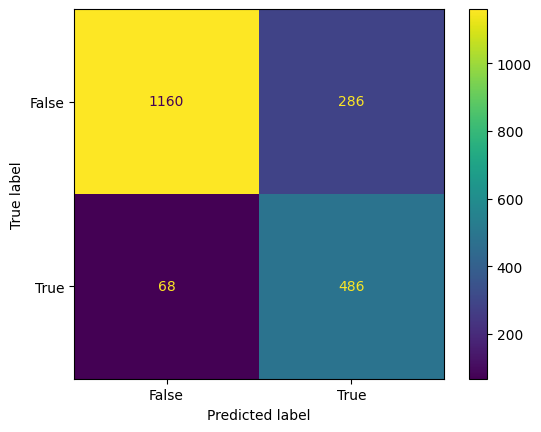

In [ ]:
# Word Embeddings

knn = KNeighborsClassifier(n_jobs=-1)
# fit model on training data
knn.fit(xtrain_embed, ytrain_embed)
# make predictions on validation data
ypred = knn.predict(xval_embed)
# evaluation
evaluation(yval_embed, ypred)

### 7.3.3 Logistic Regression

Accuracy     0.825000
Precision    0.644886
Recall       0.819495
F1-Score     0.721781
dtype: float64

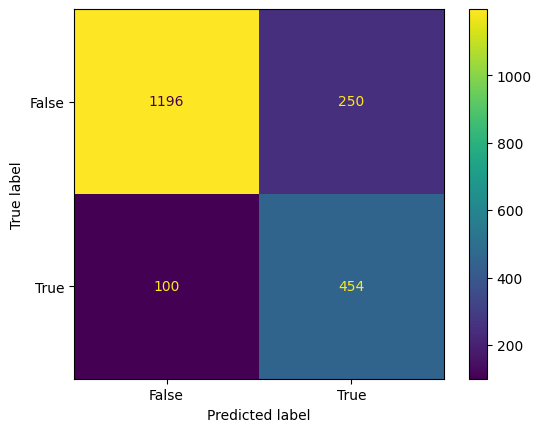

In [ ]:
lr = LogisticRegression(n_jobs=-1, random_state=420)
# fit model on training data
lr.fit(xtrain_bow, ytrain_bow)
# make predictions on validation data
ypred = lr.predict(xval_bow)
# evaluation
evaluation(yval_bow, ypred)

Accuracy     0.870500
Precision    0.714702
Recall       0.886282
F1-Score     0.791297
dtype: float64

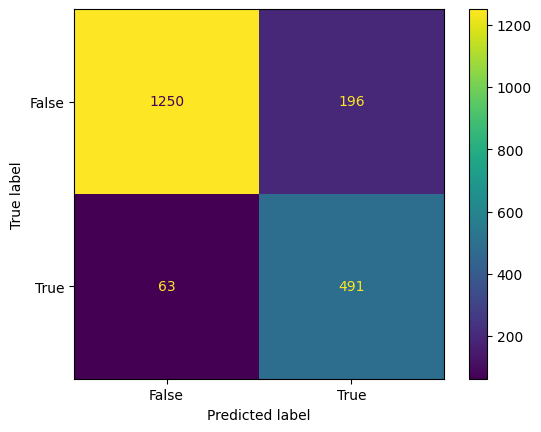

In [ ]:
# TF-IDF

lr = LogisticRegression(n_jobs=-1, random_state=420)
# fit model on training data
lr.fit(xtrain_tfidf, ytrain_tfidf)
# make predictions on validation data
ypred = lr.predict(xval_tfidf)
# evaluation
evaluation(yval_tfidf, ypred)

Accuracy     0.873500
Precision    0.732612
Recall       0.855596
F1-Score     0.789342
dtype: float64

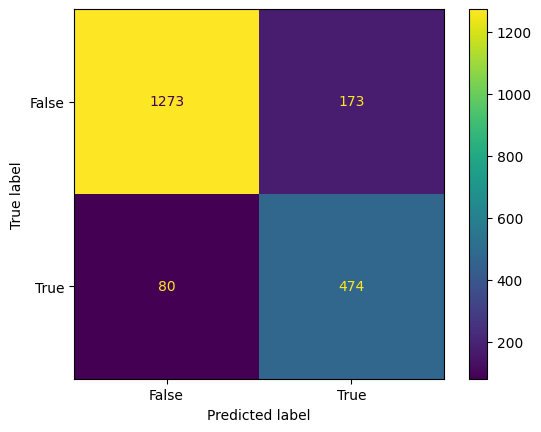

In [ ]:
# Skip-Grams

lr = LogisticRegression(n_jobs=-1, random_state=420)
# fit model on training data
lr.fit(xtrain_skip, ytrain_skip)
# make predictions on validation data
ypred = lr.predict(xval_skip)
# evaluation
evaluation(yval_skip, ypred)

Accuracy     0.875500
Precision    0.734977
Recall       0.861011
F1-Score     0.793017
dtype: float64

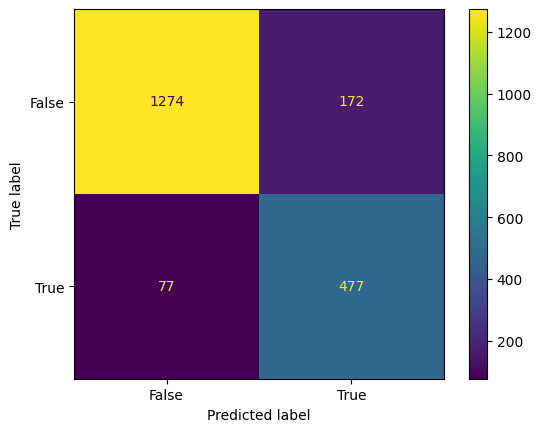

In [ ]:
# Word Embedding

lr = LogisticRegression(n_jobs=-1, random_state=420)
# fit model on training data
lr.fit(xtrain_embed, ytrain_embed)
# make predictions on validation data
ypred = lr.predict(xval_embed)
# evaluation
evaluation(yval_embed, ypred)

### 7.3.4 RandomForest

Accuracy     0.896500
Precision    0.797599
Recall       0.839350
F1-Score     0.817942
dtype: float64

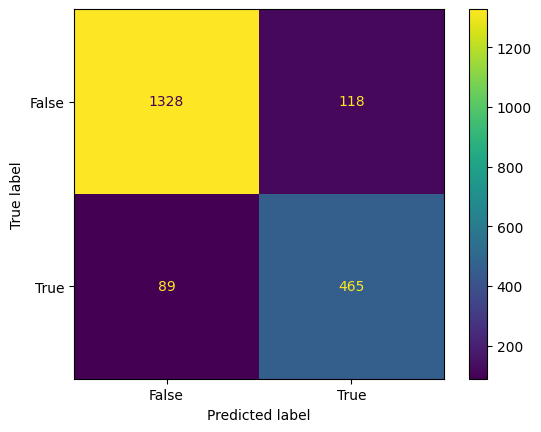

In [ ]:
# Bag-of-Words

rf = RandomForestClassifier(n_jobs=-1, random_state=420)
# fit model on training data
rf.fit(xtrain_bow, ytrain_bow)
# make predictions on validation data
ypred = rf.predict(xval_bow)
# evaluation
evaluation(yval_bow, ypred)

Accuracy     0.895500
Precision    0.798960
Recall       0.832130
F1-Score     0.815208
dtype: float64

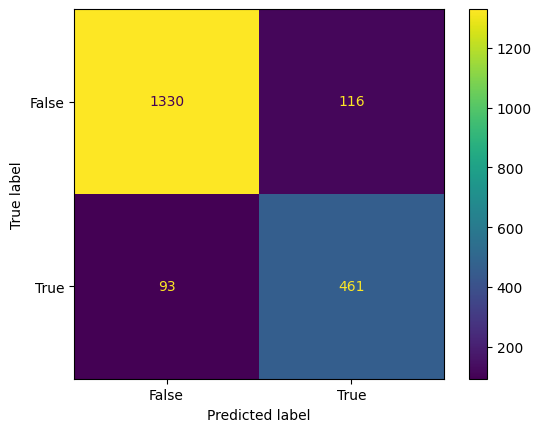

In [ ]:
# TF-IDF

rf = RandomForestClassifier(n_jobs=-1, random_state=420)
# fit model on training data
rf.fit(xtrain_tfidf, ytrain_tfidf)
# make predictions on validation data
ypred = rf.predict(xval_tfidf)
# evaluation
evaluation(yval_tfidf, ypred)

Accuracy     0.894500
Precision    0.790186
Recall       0.842960
F1-Score     0.815721
dtype: float64

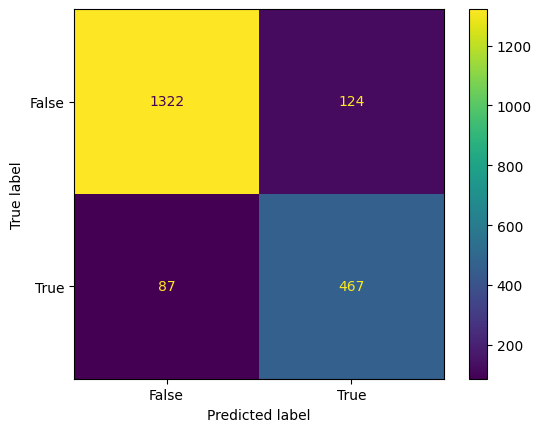

In [ ]:
# Skip-Grams

rf = RandomForestClassifier(n_jobs=-1, random_state=420)
# fit model on training data
rf.fit(xtrain_skip, ytrain_skip)
# make predictions on validation data
ypred = rf.predict(xval_skip)
# evaluation
evaluation(yval_skip, ypred)

Accuracy     0.894500
Precision    0.790186
Recall       0.842960
F1-Score     0.815721
dtype: float64

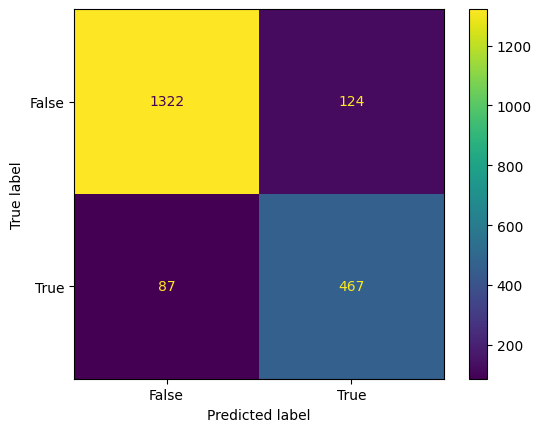

In [ ]:
# Word Embedding

rf = RandomForestClassifier(n_jobs=-1, random_state=420)
# fit model on training data
rf.fit(xtrain_embed, ytrain_embed)
# make predictions on validation data
ypred = rf.predict(xval_embed)
# evaluation
evaluation(yval_embed, ypred)

### 7.3.5 MLPClassifier

Accuracy     0.881500
Precision    0.789762
Recall       0.779783
F1-Score     0.784741
dtype: float64

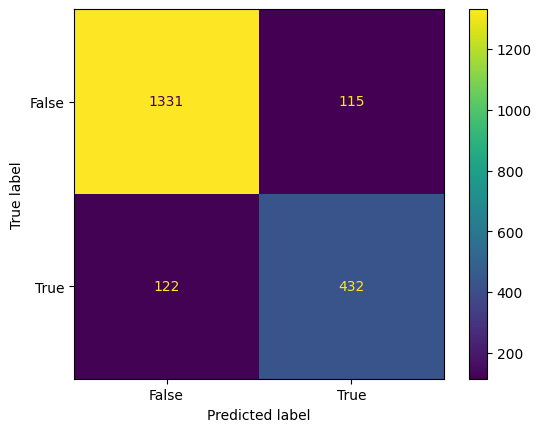

In [ ]:
# Bag-of-Words

nn = MLPClassifier(
                hidden_layer_sizes=(100,50,10),
                max_iter=500,
                early_stopping=True,
                random_state=420
                )
# fit model on training data
nn.fit(xtrain_bow, ytrain_bow)
# make predictions on validation data
ypred = nn.predict(xval_bow)
# evaluation
evaluation(yval_bow, ypred)

Accuracy     0.887500
Precision    0.794275
Recall       0.801444
F1-Score     0.797844
dtype: float64

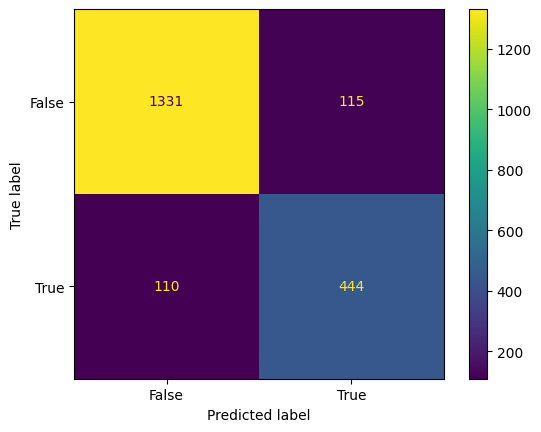

In [ ]:
# TF-IDF

nn = MLPClassifier(
                hidden_layer_sizes=(100,50,10),
                max_iter=100,
                early_stopping=True,
                random_state=420
                )
# fit model on training data
nn.fit(xtrain_tfidf, ytrain_tfidf)
# make predictions on validation data
ypred = nn.predict(xval_tfidf)
# evaluation
evaluation(yval_tfidf, ypred)

Accuracy     0.877000
Precision    0.758389
Recall       0.815884
F1-Score     0.786087
dtype: float64

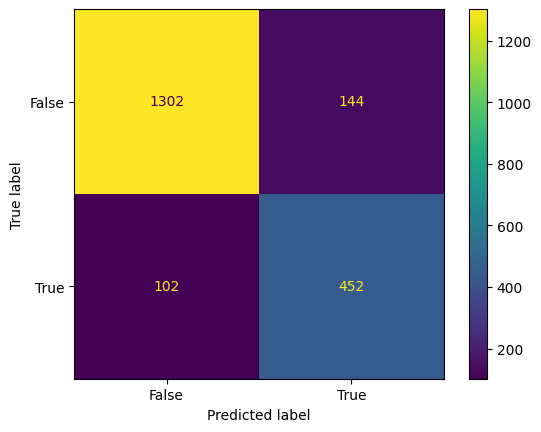

In [ ]:
# Skip-Grams

nn = MLPClassifier(
                hidden_layer_sizes=(100,50,10),
                max_iter=100,
                early_stopping=True,
                random_state=420
                )
# fit model on training data
nn.fit(xtrain_skip, ytrain_skip)
# make predictions on validation data
ypred = nn.predict(xval_skip)
# evaluation
evaluation(yval_skip, ypred)

Accuracy     0.874500
Precision    0.748768
Recall       0.823105
F1-Score     0.784179
dtype: float64

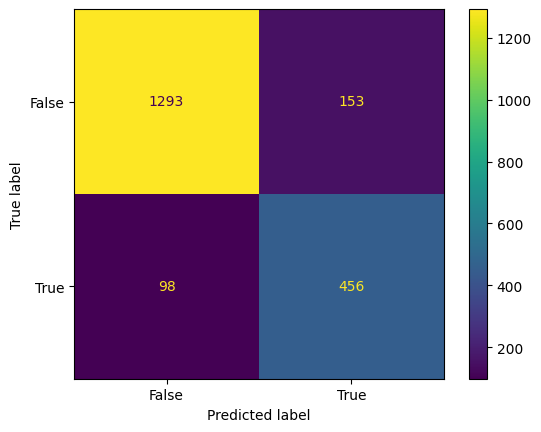

In [ ]:
# Word Embedding

nn = MLPClassifier(
                hidden_layer_sizes=(100,50,10),
                max_iter=100,
                early_stopping=True,
                random_state=420
                )
# fit model on training data
nn.fit(xtrain_embed, ytrain_embed)
# make predictions on validation data
ypred = nn.predict(xval_embed)
# evaluation
evaluation(yval_embed, ypred)

### 7.3.6 Threshold Shifting

In [ ]:
# TF-IDF

rf = RandomForestClassifier(n_jobs=-1, random_state=420)
# fit model on training data
rf.fit(xtrain_tfidf, ytrain_tfidf)
# make predictions on validation data
ypred = rf.predict_proba(xval_tfidf)

In [ ]:
d = {}

for threshold in np.arange(0, 1, 0.01):
    predicted_labels = (ypred[:, 1] >= threshold).astype(int)
    # Evaluate the performance or do further processing with the predicted labels
    d[threshold] = [f1_score(yval_tfidf, predicted_labels), accuracy_score(yval_tfidf, predicted_labels), precision_score(yval_tfidf, predicted_labels), recall_score(yval_tfidf, predicted_labels)]


pd.DataFrame(d).T.rename(columns={0:'f1_score', 1:'accuracy_score', 2:'precision_score', 3:'recall_score'}).sort_values(by='f1_score', ascending=False).head(5)

,f1_score,accuracy_score,precision_score,recall_score
0.35,0.819421,0.8940,0.775806,0.868231
0.36,0.819421,0.8940,0.775806,0.868231
0.44,0.818103,0.8955,0.789916,0.848375
0.37,0.817793,0.8935,0.777236,0.862816
0.43,0.817708,0.8950,0.787625,0.850181


## 7.4 TensorFlow Model

### 7.4.1 Function - Data to Tensor

In [ ]:
def tensorflow_data(xtrain, xval, xtest, ytrain, yval, ytest):
    '''
    Transforms the train/val/test split into tensors
    Input: xtrain, xval, xtest, ytrain, yval, ytest
    Output: xtrain, xval, xtest, ytrain, yval, ytest
    '''

    # x to tensor
    xtrain = tf.convert_to_tensor(np.expand_dims(xtrain, axis=2))
    xval = tf.convert_to_tensor(np.expand_dims(xval, axis=2))
    xtest = tf.convert_to_tensor(np.expand_dims(xtest, axis=2))

    # y to tensor
    ytrain = tf.convert_to_tensor(np.reshape(ytrain, (ytrain.shape[0], 1)))
    yval = tf.convert_to_tensor(np.reshape(yval, (yval.shape[0], 1)))
    ytest = tf.convert_to_tensor(np.reshape(ytest, (ytest.shape[0], 1)))

    return xtrain, xval, xtest, ytrain, yval, ytest

In [ ]:
xtrain_tf, xval_tf, xtest_tf, ytrain_tf, yval_tf, ytest_tf = tensorflow_data(xtrain_embed, xval_embed, xtest_embed, ytrain_embed, yval_embed, ytest_embed)

### 7.4.2 Recurrent Neural Networks

In [ ]:
# define input shape of xtrain_tf
input_shape = xtrain_tf.shape[1:]

# define model
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # SimpleRNN layer
    tf.keras.layers.SimpleRNN(50, return_sequences=True),
    # SimpleRNN layer
    tf.keras.layers.SimpleRNN(20),
    # ouptut layer
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# compile model
model_rnn.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=[
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
                ]
            )

# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# fit model
rnn = model_rnn.fit(
                x=xtrain_tf,
                y=ytrain_tf,
                validation_data=(xval_tf, yval_tf),
                epochs=20,
                callbacks=[early_stopping]
                )

os.makedirs('Models/rnn', exist_ok=True)
model_rnn.save('Models/rnn/model_rnn.h5')

79/79 [==============================] - 31s 373ms/step


Accuracy     0.863600
Precision    0.717284
Recall       0.838384
F1-Score     0.773120
dtype: float64

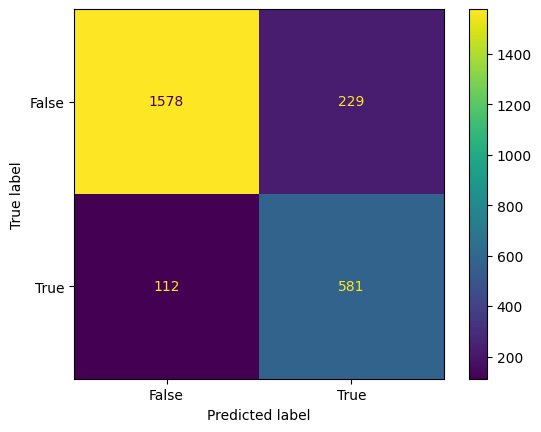

In [ ]:
# load model
model_rnn = tf.keras.models.load_model('Models/rnn/model_rnn.h5')
# Evaluate the model on the test data
ypred = np.round(model_rnn.predict(xtest_tf))
# evaluate
evaluation(ytest_tf, ypred)

## 7.5 Transfer Learning

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1'

### 7.5.1 Load & Prepare Datasets

In [ ]:
# load textual data
combined_bert_preprocessing = pd.read_csv('Data/combined_bert_preprocessing.csv', index_col='index', keep_default_na=False)

# string columns to numpy
combined_bert_preprocessing.iloc[:,1:4] = combined_bert_preprocessing.iloc[:,1:4].applymap(lambda x: np.array(ast.literal_eval(x)) if x != '' else x)

# combine sentences in text columns
combined_bert_preprocessing.iloc[:,1:4] = combined_bert_preprocessing.iloc[:,1:4].applymap(lambda x: ' '.join(x) if isinstance(x, np.ndarray) else x)

# rename label column
combined_bert_preprocessing = combined_bert_preprocessing.rename(columns={'unlisted':'label'})

# get train/test/val split from above
tvt_split = pd.read_csv('Data/Bert/data.csv', index_col='index', keep_default_na=False)['dataset']
train, val, test = list(combined_bert_preprocessing[tvt_split=='xtrain'].index), list(combined_bert_preprocessing[tvt_split=='xval'].index), list(combined_bert_preprocessing[tvt_split=='xtest'].index)

# split data
bert_train = combined_bert_preprocessing[combined_bert_preprocessing.index.isin(train)]
bert_val = combined_bert_preprocessing[combined_bert_preprocessing.index.isin(val)]
bert_test = combined_bert_preprocessing[combined_bert_preprocessing.index.isin(test)]

# exclude feature engineering
bert_train, bert_train_fe = bert_train.iloc[:, :-5], bert_train.iloc[:, -5:]

### 7.5.2 Function - Save Data to Directory

In [ ]:
def sort_dataframe_to_directory(df, main_directory, class_column, text_column):
    os.makedirs(main_directory, exist_ok=True)

    unique_classes = df[class_column].unique()

    for class_name in unique_classes:
        class_directory = os.path.join(main_directory, str(class_name))
        os.makedirs(class_directory, exist_ok=True)

        class_df = df[df[class_column] == class_name]

        for index, row in class_df.iterrows():
            text = row[text_column]
            text_file = f"{class_name}_text_{index}.txt"
            text_file_path = os.path.join(class_directory, text_file)

            with open(text_file_path, 'w') as file:
                file.write(text)

#### 7.5.2.1 Save Description Column Data to Directory

In [ ]:
sort_dataframe_to_directory(
    bert_train,
    main_directory='Data/nlp_data/description/train/',
    class_column='label',
    text_column='description'
    )

sort_dataframe_to_directory(
    bert_val,
    main_directory='Data/nlp_data/description/val/',
    class_column='label',
    text_column='description'
    )

sort_dataframe_to_directory(
    bert_test,
    main_directory='Data/nlp_data/description/test/',
    class_column='label',
    text_column='description'
    )

#### 7.5.2.2 Save Host About Column Data to Directory

In [ ]:
sort_dataframe_to_directory(
    bert_train,
    main_directory='Data/nlp_data/host_about/train/',
    class_column='label',
    text_column='host_about'
    )

sort_dataframe_to_directory(
    bert_val,
    main_directory='Data/nlp_data/host_about/val/',
    class_column='label',
    text_column='host_about'
    )

sort_dataframe_to_directory(
    bert_test,
    main_directory='Data/nlp_data/host_about/test/',
    class_column='label',
    text_column='host_about'
    )

#### 7.5.2.3 Save Comments Column Data to Directory

In [ ]:
sort_dataframe_to_directory(
    bert_train,
    main_directory='Data/nlp_data/comments/train/',
    class_column='label',
    text_column='comments'
    )

sort_dataframe_to_directory(
    bert_val,
    main_directory='Data/nlp_data/comments/val/',
    class_column='label',
    text_column='comments'
    )

sort_dataframe_to_directory(
    bert_test,
    main_directory='Data/nlp_data/comments/test/',
    class_column='label',
    text_column='comments'
    )

### 7.5.3 Load Data from Directory

#### 7.5.3.1 Load Description Column Data

In [ ]:
train_desc = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/description/train/',
    batch_size=32,
    seed=420
    )

train_description = train_desc.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_desc = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/description/val/',
    batch_size=32,
    seed=420
    )

val_description = val_desc.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_desc = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/description/test/',
    batch_size=32,
    seed=420
    )

test_description = test_desc.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### 7.5.3.2 Load Host About Column Data

In [ ]:
train_host = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/host_about/train/',
    batch_size=32,
    seed=420
    )

train_host_about = train_host.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_host = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/host_about/val/',
    batch_size=32,
    seed=420
    )

val_host_about = val_host.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_host = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/host_about/test/',
    batch_size=32,
    seed=420
    )

test_host_about = test_host.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### 7.5.3.3 Load Comments Column Data

In [ ]:
train_cmts = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/comments/train/',
    batch_size=32,
    seed=420
    )

train_comments = train_cmts.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_cmts = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/comments/val/',
    batch_size=32,
    seed=420
    )

val_comments = val_cmts.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_cmts = tf.keras.utils.text_dataset_from_directory(
    'Data/nlp_data/comments/test/',
    batch_size=32,
    seed=420
    )

test_comments = test_cmts.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 7.5.4 Function - Build Classifier Model

In [ ]:
def build_classifier_model(dropout_rate=0.5):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(dropout_rate)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.AUC(name='auc')
      ]

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_comments).numpy()

init_lr = 3e-5
optimizer = Adam(learning_rate=init_lr)

### 7.5.5 Train Models on Columns

#### 7.5.5.1 Train Description Column Model

In [ ]:
model_description = build_classifier_model(dropout_rate=0.5)

model_description.compile(
                    optimizer=optimizer,
                    loss=loss,
                    metrics=metrics
                    )

In [ ]:
model_description.fit(
                x=train_description,
                validation_data=val_description,
                epochs=epochs
                )

os.makedirs('Models/description', exist_ok=True)
model_description.save('Models/description/model_description.h5')

#### 7.5.5.2 Train Host About Column Model

In [ ]:
model_host_about = build_classifier_model(dropout_rate=0.2)

model_host_about.compile(
                    optimizer=optimizer,
                    loss=loss,
                    metrics=metrics
                    )

In [ ]:
model_host_about.fit(
                x=train_host_about,
                validation_data=val_host_about,
                epochs=epochs
                )

os.makedirs('Models/host_about', exist_ok=True)
model_host_about.save('Models/host_about/model_host_about.h5')

#### 7.5.5.1 Train Comments Column Model

In [ ]:
model_comments = build_classifier_model(dropout_rate=0.2)

model_comments.compile(
                    optimizer=optimizer,
                    loss=loss,
                    metrics=metrics
                    )

In [ ]:
model_comments.fit(
                x=train_comments,
                validation_data=val_comments,
                epochs=epochs
                )

os.makedirs('Models/comments', exist_ok=True)
model_comments.save('Models/comments/model_comments.h5')

### 7.5.6 Model Stacking

#### 7.5.6.1 Load Saved Models

In [ ]:
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the models with the custom objects
model_description = tf.keras.models.load_model('Models/description/model_description.h5', custom_objects=custom_objects)
model_host_about = tf.keras.models.load_model('Models/host_about/model_host_about.h5', custom_objects=custom_objects)
model_comments = tf.keras.models.load_model('Models/comments/model_comments.h5', custom_objects=custom_objects)

#### 7.5.6.2 Function - Stacking Multiple Models

In [ ]:
def build_stacking_model():
    train_pred_input = tf.keras.layers.Input(shape=(3,), name='train_pred_input')

    dense = tf.keras.layers.Dense(64, activation='relu')(train_pred_input)
    dense = tf.keras.layers.Dense(64, activation='relu')(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.Model(inputs=train_pred_input, outputs=output)

    return model

#### 7.5.6.3 Predictions on Train/Validation

In [ ]:
train_predictions_model_description = model_description.predict(train_description)
train_predictions_model_host_about = model_host_about.predict(train_host_about)
train_predictions_model_comments = model_comments.predict(train_comments)

val_predictions_model_description = model_description.predict(val_description)
val_predictions_model_host_about = model_host_about.predict(val_host_about)
val_predictions_model_comments = model_comments.predict(val_comments)

train_data_stacking = np.concatenate((train_predictions_model_comments, train_predictions_model_host_about, train_predictions_model_description), axis=1)
val_data_stacking = np.concatenate((val_predictions_model_comments, val_predictions_model_host_about, val_predictions_model_description), axis=1)

63/63 [==============================] - 141s 2s/step


In [ ]:
train_labels = []
for _, label_batch in train_comments:
    train_labels.extend(label_batch.numpy().tolist())

val_labels = []
for _, label_batch in val_comments:
    val_labels.extend(label_batch.numpy().tolist())


train_labels = np.array(train_labels).reshape(-1)
val_labels = np.array(val_labels).reshape(-1)

#### 7.5.6.4 Train Stacking Model

In [ ]:
model_stacking = build_stacking_model()

# compile model
model_stacking.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=metrics)

In [ ]:
# fit model
model_stacking.fit(
        train_data_stacking,
        train_labels,
        validation_data=(val_data_stacking, val_labels),
        epochs=30,
        batch_size=32,
        )

os.makedirs('Models/stacking', exist_ok=True)
model_stacking.save('Models/stacking/model_stacking.h5')

#### 7.5.6.5 Evaluate Stacking Model

In [ ]:
# Load the stacking model
model_stacking = tf.keras.models.load_model('Models/stacking/model_stacking.h5')

In [ ]:
test_predictions_model_description = model_description.predict(test_description)
test_predictions_model_host_about = model_host_about.predict(test_host_about)
test_predictions_model_comments = model_comments.predict(test_comments)

test_data_stacking = np.concatenate((test_predictions_model_comments, test_predictions_model_host_about, test_predictions_model_description), axis=1)

79/79 [==============================] - 24s 264ms/step


In [ ]:
test_labels = []
for _, label_batch in test_comments:
    test_labels.extend(label_batch.numpy().tolist())

test_labels = np.array(test_labels).reshape(-1)

Accuracy     0.861600
Precision    0.830476
Recall       0.629149
F1-Score     0.715928
dtype: float64

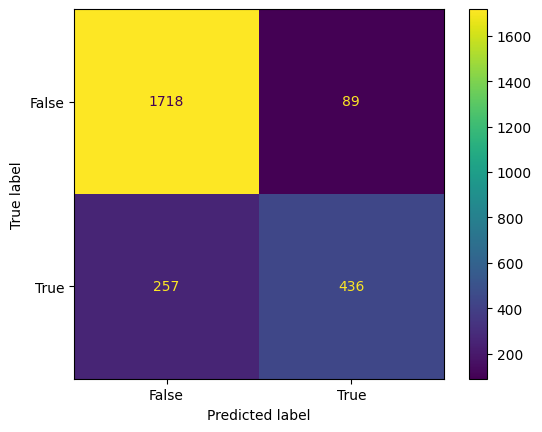

In [ ]:
from nltk.sem.util import evaluate
ypred = np.round(model_stacking.predict(test_data_stacking, verbose=0))

# evaluation
evaluation(test_labels, ypred)

## 7.6 Final Model & Predictions

### 7.6.1 Grid Search

In [ ]:
# combine train and val data for grid search
xtrain = np.concatenate((xtrain_skip, xval_skip), axis=0)
ytrain = np.concatenate((ytrain_skip, yval_skip), axis=0)

In [ ]:
# Grid Search on Word Embeddings

# define parameter grid RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
    }

grid_search = GridSearchCV(
                        estimator=RandomForestClassifier(n_jobs=-1, random_state=420),
                        param_grid=param_grid,
                        cv=3,
                        scoring='f1',
                        verbose=2,
                        n_jobs=-1
                        )

grid_search.fit(xtrain, ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=420),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=2)

Accuracy     0.894800
Precision    0.794521
Recall       0.836941
F1-Score     0.815179
dtype: float64

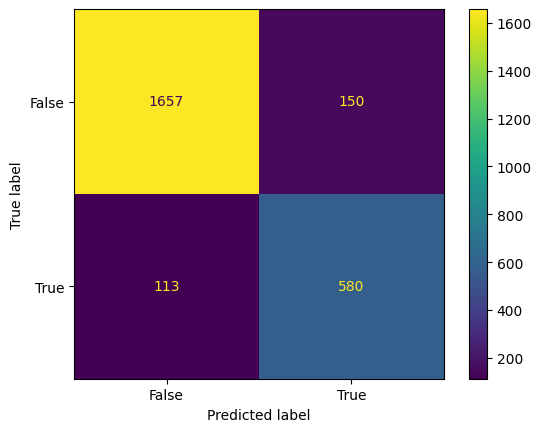

In [ ]:
# evaluate on test data
ypred_grid = grid_search.predict(xtest_skip)
# print classification report
evaluation(ytest_skip, ypred_grid)

### 7.6.2 Train Final Model

In [ ]:
# combine train and test data for final model
xtrain = np.concatenate((xtrain, xtest_skip), axis=0)
ytrain = np.concatenate((ytrain, ytest_skip), axis=0)

In [ ]:
rf_final = RandomForestClassifier(**grid_search.best_params_, n_jobs=-1, random_state=420)
# fit model on training data
rf_final.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=30, n_estimators=300, n_jobs=-1,
                       random_state=420)

### 7.6.3 Prepare Test Data

In [ ]:
test = pd.read_excel('Data/test.xlsx', index_col='index')
test_reviews = pd.read_excel('Data/test_reviews.xlsx', index_col='index')

#### 7.6.3.1 Preprocessing

In [ ]:
test = text_preprocessing(test)
test_reviews = text_preprocessing(test_reviews)

#### 7.6.3.2 Sentiment Analysis

In [ ]:
test_reviews_sentiment = sentiment_analysis(test_reviews)

#### 7.6.3.3 Combine Data

In [ ]:
# re-order columns
test_df = test[['description', 'host_about']]
test_reviews_df = test_reviews_sentiment[['comments', 'avg_compound', 'num_comments', 'num_pos', 'num_neg', 'num_neu']]

# merge train and train-reviews datasets
combined_standard_preprocessing = pd.merge(test_df, test_reviews_df, left_index=True, right_index=True, how='left')

# get numeric/non-numeric columns
numeric_cols = combined_standard_preprocessing.select_dtypes(include=np.number).columns.tolist()
non_numeric_cols = combined_standard_preprocessing.select_dtypes(exclude=np.number).columns.tolist()
# fillna for numeric columns
combined_standard_preprocessing[numeric_cols] = combined_standard_preprocessing[numeric_cols].fillna(0)
# fillna for non-numeric columns
combined_standard_preprocessing[non_numeric_cols] = combined_standard_preprocessing[non_numeric_cols].fillna('')

In [ ]:
combined_standard_preprocessing.head(3)

,description,host_about,comments,avg_compound,num_comments,num_pos,num_neg,num_neu
index,,,,,,,,
1,space apartment locate historic center lisbon ...,gost de viaj de conhec pesso gost de receb os ...,thank much antonio perfect stay appartment per...,0.764742,125.0,41.0,0.0,84.0
2,important response covid property extend clean...,home team count us take care every single deta...,beautiful bright apartment residential area li...,0.609427,11.0,2.0,0.0,9.0
3,bright beautiful spacious four bedroom apartme...,hi guestready professional property management...,,0.000000,0.0,0.0,0.0,0.0


#### 7.6.3.4 Skip Grams

In [ ]:
def skipgram_encoder(data, vector_size=100, window=5, min_count=1):
    """
    Encodes the text data using skip-gram vectorization
    Input: xtrain, xval, xtest, vector_size (optional), window (optional), min_count (optional)
    Output: transformed dataframe with skip-gram vectors applied column-wise
    """

    # Exclude feature engineering
    data, data_fe = data.iloc[:, :-5], data.iloc[:, -5:]

    for col in data.columns:
        # Train Word2Vec model on the column data
        sentences = data[col].apply(lambda x: x.split())
        model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, sg=1)

        # Transform xtrain, xval, xtest column
        data[col] = data[col].apply(lambda x: np.mean([model.wv[word] for word in x.split() if word in model.wv], axis=0))

        # Fill empty cells and convert to python list
        data[col] = data[col].apply(lambda x: list(np.zeros(vector_size)) if isinstance(x, float) and pd.isnull(x) else list(x))

    # Merge with feature engineering columns again
    data = pd.merge(data, data_fe, left_index=True, right_index=True, how='left')

    return data

In [ ]:
test_skip = skipgram_encoder(combined_standard_preprocessing)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


#### 7.6.3.5 Prepare Dataframe

In [ ]:
def prepare_final_data(dataframe):

  comments = np.vstack(dataframe['comments'].to_numpy())
  description = np.vstack(dataframe['description'].to_numpy())
  host_about = np.vstack(dataframe['host_about'].to_numpy())
  avg_compound = dataframe[['avg_compound']].to_numpy()
  num_comments = dataframe[['num_comments']].to_numpy()
  num_pos = dataframe[['num_pos']].to_numpy()
  num_neg = dataframe[['num_neg']].to_numpy()
  num_neu = dataframe[['num_neu']].to_numpy()

  x = np.hstack((comments, description, host_about, avg_compound, num_comments, num_pos, num_neg, num_neu))

  return x

In [ ]:
test_skip_final = prepare_final_data(test_skip)

#### 7.6.3.6 Predict

In [ ]:
final_predictions = rf_final.predict(test_skip_final)
final_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
submission = pd.DataFrame({'airbnb_id': test.index, 'prediction': final_predictions})

In [ ]:
submission

,airbnb_id,prediction
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1384,1385,0
1385,1386,0
1386,1387,0
1387,1388,0


In [ ]:
submission.to_csv('Predictions_Group23.csv', index=False)